### CaseII: Hurricane Michael Composite and Wavelet Analysis

This notebook demonstrates how band-pass filtered perturbations are composited and subsequently analyzed using correlation lag-analysis (Rees and Mobbs, 1988), beamstearing (Rees et al., 2000), and wavelet analysis (Casagrande et al., 2015)

Cross correlation lag-analysis and beamsteering are used to calculate wave-normal winds (u*). In this study, the wave-normal wind is defined as the wind component in the direction of feature propagation (Koch and Siedlarz, 1999). Note, that while not all features are associated with "waves" calculating (u*) can help classify the nature of the feature (e.g. whether or not its AGW). This classification is facillitated through wavelet analysis, which is employed to reveal multiscale cross-correlation and phase relationships between pressure, temperature, wind, and humidity perturbations. 

1. Import relevant Python libraries and setup cartopy/colortables

2. Methodology. Functions defining band pass filtering, feature tracking, cross-correlation lag analysis, beamsteering, and wavelet analysis

3. Retrieve and plot composite analyses of pressure, temperature, humidity, and wave-normal wind perturbations for Case I: Mesoscale Convective System 

4. Demonstrate how cross-correlation lag analysis and beamsteering are used to estimate phase speed and wave-normal wind components.

5. Perform wavelet analysis and cross wavelet analysis to evaluate multi-scale relationships between pressure, temperature, humidity, and wind perturbations. 
   Calculate and display wavelet cross correlation, coherence, and phase at all feature track points and at the dominant scale of the observed pressure feature

In [9]:
### ---- (1) ---- ####
#Import Python libraries

import os
import sys
sys.path.append('../../PyScripts')
import xarray as xr
import matplotlib
import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import funcs
import sys
import lcmaps
import colorcet as cc
import cmasher as cmr
from datetime import datetime,timedelta
from cartopy.feature import NaturalEarthFeature,BORDERS,LAKES,COLORS
import cartopy.crs as crs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from metpy.plots import colortables
from scipy import ndimage
import pandas as pd
from sklearn.cluster import DBSCAN
from scipy.signal import butter, lfilter
from matplotlib import cm
import multiprocessing
from joblib import Parallel,delayed
import py_wavelets_orig
from scipy import signal,stats,ndimage
from scipy.signal import find_peaks,peak_widths
from skimage.measure import regionprops_table
import trackpy as tp
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

#Retrieve perceptually uniform colorbar from colorcet
cmapp = cc.cm.rainbow_bgyrm_35_85_c71

#Set format for datetime objects
fmt = '%Y%m%d_%H%M'

# Download/add state and coastline features for cartopy 
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")

land_50m = NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor='none')

#Define function to add map data to matplotlib plot
def add_map(ax,clr,lw):
    ax.add_feature(states)
    ax.add_feature(BORDERS)
    ax.add_feature(land_50m)
    ax.add_feature(states,edgecolor=clr,lw=lw)
    ax.add_feature(LAKES, edgecolor=clr)

#Define function to add latitude/longitude grid lines to cartopy/matplotlib plot
def add_gridlines(ax,xl,yl,clr, fs):
    gl = ax.gridlines(crs=crs.PlateCarree(), draw_labels=True,
                      linewidth=0.25, color=clr, alpha=1, linestyle='--')

    gl.xlabels_bottom = xl
    gl.xlabels_top = False
    gl.ylabels_left = yl
    gl.ylabels_right = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': fs, 'color': clr}
    gl.ylabel_style = {'size': fs, 'color': clr}
    return gl

#Get Composite Reflectivity colormap from metpy

ctable0 = 'Carbone42'
ctable1 = 'NWSStormClearReflectivity'
ctable2 = 'ir_rgbv'

cmapp = cc.cm.rainbow_bgyrm_35_85_c71

norm1, cmapp_prs = colortables.get_with_steps(ctable0, 140, 140)
norm, cmapp_radar = colortables.get_with_steps(ctable1, 244, 244)
norm2, cmapp_sat = colortables.get_with_steps(ctable2, 140, 140)

#Increase with of notebook to fill screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Define function to mask pressure analyses over water
def mask_grid(arr):
    arr = np.ma.masked_where(landsea==0,arr)
    return arr

#Define function to read and subset a land/sea boolean grid
def get_landsea():
    ds_land = xr.open_dataset('../data/Static/landsea.nc')
    ds_land = funcs.subset(ds_land,minLat,maxLat,minLng,maxLng)
    landsea = ds_land['LANDSEA'].values
    landsea = np.pad(landsea, ((0,1),(0,1)), 'edge')
    ds_land.close()
    return landsea

def get_bounds(lats,lngs):

    clat = np.mean(lats)
    clng = np.mean(lngs)

    dy = round((lats.max()-lats.min())+1)
    dx = round((lngs.max()-lngs.min())+1)

    if (dy < 2.5):
        dy = 2.5

    dx = dy*1.75

    #if (dy < 2.5):

    minLat = clat-dy
    maxLat = clat+dy
    minLng = clng-dx
    maxLng = clng+dx

    bounds = [minLat,maxLat,minLng,maxLng]
    return bounds

In [10]:
### ---- (2) ---- ####
### Define functions for composite and wavelet analysis ###

#Basic functions for performing band pass filtering and calculating cross-correlations

#Perform cross correlation between two N-D arrays
def xcr(arr1,arr2):
    arr1 = (arr1-arr1.mean())/(arr1.std()*len(arr1))
    arr2 = (arr2-arr2.mean())/arr2.std()
    xcor = signal.correlate(arr1,arr2,'same')
    return xcor

#Highpass filter
lowcut = 1/(3600*6)
highcut = 1/(3600*6)
fs = 1/300.0
order = 2

#Provide functions to bandpass filter an array
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype = 'highpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def filter_ts(pprime):
    meso = butter_bandpass_filter(pprime, lowcut, highcut, fs, order)
    return meso

#Bandpass filter an array
def bpass(vvar):
    meso = np.zeros(vvar.shape)
    for i in range(0,vvar.shape[1]):
            for j in range(0,vvar.shape[2]):
                    vtmp = vvar[:,i,j]
                    barr = filter_ts(vtmp)
                    meso[:,i,j] = barr
    return meso

In [11]:
#Functions for lag analysis (method of determining direction and speed of pressure features)
#These approaches are outlined in Nappo (2013), Chapter 10.2.5-10.2.6 and first demonstrated by Rees and Mobbs (1988)

t2 = np.arange(-6*60,6*60,5) #12-h time window for compositing analysis (analysis every 5-min)

#Compute the time difference between peak correlation at select grid points
def avg_ang(cmax,dx,dy,st,et):
    #Initialize grid
    xs = np.arange(st,et,dx)
    ys = np.arange(st,et,dy)
    xd = []; ux = np.zeros((len(xs),len(ys))); vx = np.zeros((len(xs),len(ys))); xx2 = np.zeros((len(xs),len(ys))); yy2 = np.zeros((len(xs),len(ys)))
    for i,x in enumerate(xs):
            for j,y in enumerate(ys):
                    #Note correlation analysis can be performed at different scales (dx = 8 works well; produces results consistent with beamsteering) | dx*5 km (grid size) = 40km.    
                    #Since we have a gridded analysis we can "pick" our stations to be select grid points
                    
                    #(RHS Eq. 10.22-10.23; Nappo, 2013)
                    dfdx = cmax[y,x+dx]-cmax[y,x-dx] #Time difference between peak correlation (at 40 km east and + 40km west from point y,x)
                    dfdy = cmax[y+dy,x]-cmax[y-dy,x] #Time difference between peak correlation (at 40 km north and + 40km south from point y,x)

                    #Fill pre-defined grid with zonal and meridional correlation lag (i.e. time difference between peak correlation).
                    ux[i,j] = dfdx
                    vx[i,j] = dfdy

    return ux,vx,xs,ys

#Using lag-analysis derive tau in the meridional and zonal directions using Eq. 10.22-10.33 Nappo, 2013
#Note that tau is the time difference between sets of synthetic stations (ie. grid points) chosen along a north-south (meridional) and east-west (zonal) axis.
def get_uv(parr,dx,win=True,plott=False):
    
    #Compute auto-correlation of N-D mesoscale pressure perturbation array
    xcorr = signal.correlate(parr,parr,mode='same')
    
    #Retrieve index of maximum correlatoin along the record dimension.
    cmax = xcorr.argmax(axis=0)
    cmax0 = cmax.copy()

    #Perform lag analysis
    dy = dx
    u,v,xx2,yy2 = avg_ang(cmax,dx,dy,dx,50-dx)

    #mask array where peak lag difference is nill or above a specified threshold
    xx2 = np.array(xx2); yy2 = np.array(yy2)
    
    #threshold to remove large peak correlation time differences (possible if more than one feature is present in the composite).
    u1 = np.ma.masked_where(abs(u)>35,u)
    v1 = np.ma.masked_where(abs(v)>35,v)
    u2 = np.ma.masked_where((u1==0) & (v1==0),u1)
    v2 = np.ma.masked_where((u1==0) & (v1==0),v1)

    #Compute the mean of peak time lags in the meridional and zonal direction
    um = np.mean(u2)
    vm = np.mean(v2)
    
    #Eq. 10.25 (Nappo, 2013)
    #Derive azimuth of phase propogation
    alpha= np.arctan2(-um,-vm) #Direction toward which feature is moving
    alpha_vec = np.arctan2(vm,um) #Direction toward which feature is coming from

    #Create grid 
    X,Y = np.meshgrid(np.arange(0,50),np.arange(0,50))

    #Initialize DBSCAN Unsupervied Clustering
    db = DBSCAN(eps=10,min_samples=10)

    #Convert peak corrrelation array to 1-D
    cs = cmax.flatten()
    #Convert grid array to 1-D
    XX = np.array([X.flatten(),Y.flatten(),cs]).T

    #Perform clustering
    db.fit(XX)
    #Save labels
    kml = db.labels_
    #Find mode of labels
    mcc = stats.mode(kml)[0][0]

    #Window max correlation analysis to the time of the mode cluster (prevents correlation analysis from being corrupted by previous features that may be included in composite analysis)
    gidx = np.argwhere(kml!=mcc)
    #Remove max cross correlation data outside this cluster (time) window.
    for v in gidx:
        #Get x,y index from array
        cx,cy = np.unravel_index(v,cmax.shape)
        cmax[cx,cy] = -100 #Set value to null

    #Mask peak cross correlation where values are below zero
    cmax = np.ma.masked_where(cmax<0,cmax)

    #Plot Lag Analysis Results (Time-series, DBSCAN analysis, and Cross Correlation Peak Lag)
    if (win):
            et = cmax.max()
            st = cmax.min()
            
            if (plott):
                fig1=plt.figure(figsize=(14,8))
                matplotlib.rcParams.update({'font.size': 16})
                #Show results for full time window (6-h)
                ax1=plt.subplot(121)
                plt.imshow(cmax0,origin='lower',interpolation='bilinear',cmap=plt.cm.jet,aspect='auto')
                plt.colorbar()
                ax1.set_title(r"Full Time Series $(\tau_{max})$")
                #Show results for localized time window (useful to narrow focus to feature of interest if multiple features are observed)
                ax2=plt.subplot(122)
                plt.imshow(cmax,origin='lower',interpolation='nearest',cmap=plt.cm.jet,aspect='auto')
                ax2.set_title(r"DBSCAN Localized $(\tau_{max})$")
                plt.colorbar()
                plt.tight_layout()
                plt.subplots_adjust(top=0.85)
                plt.suptitle(r"Cross Correlation Peak Lag: $(\tau_{max})$")
                plt.show()

            return st,et,cmax,u2,v2
    else:
            return cmax,xx2,yy2,u2,v2
        
#Interpolate lag analysis to grid and plot results
def grid_uv(xx2,yy2,u2,v2,dx,plott=False):
    dw = xr.Dataset()

    #Convert directional peak lag time differences into xarray data arrays
    dw['u'] = xr.DataArray(u2,coords={'x':xx2,'y':yy2},dims={'x','y'})
    dw['v'] = xr.DataArray(v2,coords={'x':xx2,'y':yy2},dims={'x','y'})

    #Fill NaNs for plotting
    dy = dx
    df = dw.to_dataframe()
    dfn = df.fillna(method='ffill')
    dfn = dfn.fillna(method='bfill')
    
    #Interpolate data to finer grid for plotting
    xnew = np.arange(xx2[0],xx2[-1],1) #xx2[0],xx2[-1]+1,1)
    ynew = np.arange(xx2[0],xx2[-1],1) #yy2[0],yy2[-1]+1,1)

    dww = dfn.to_xarray()
    dww = dww.interp(x=xnew,y=ynew)
    dww = dww.pad(x=(dx+1,dx+1),y=(dy+1,dy+1),mode='edge')

    unew = dww['u'].values
    vnew = dww['v'].values

    #Solve Eq. 10.22-10.33 (Nappo, 2013) for Slowness components (Sx and Sy)
    Sx = (unew*300)/(2*dx*5000)
    Sy = (vnew*300)/(2*dy*5000)

    new_alpha = np.arctan2(-Sx,-Sy) #Eq. 10.25 (Nappo, 2013) - Sign flipped to indicate direction FROM which the feature is propogating 
    
    #Use slowness components to estimate phase speed
    ph_speed = 1.0/((Sx**2 + Sy**2)**0.5) #Eq. 10.24 (Nappo, 2013)
    
    if (plott):
        fig1 = plt.figure(figsize=(14,8))
        matplotlib.rcParams.update({'font.size': 16})
        #Plot slowness components
        ax1=plt.subplot(221)
        im=plt.imshow(Sx,aspect='auto',origin='lower',interpolation='nearest',cmap=plt.cm.viridis)
        plt.title('$S_x$ $(s/m)$')
        plt.grid(True)
        plt.colorbar(im)
        plt.subplot(222)
        im=plt.imshow(Sy,aspect='auto',origin='lower',interpolation='nearest',cmap=plt.cm.viridis)
        plt.title('$S_y$ $(s/m)$')
        plt.grid(True)
        plt.colorbar(im)
        plt.subplot(223)
        #Plot phase speed and angle
        im=plt.imshow(np.degrees(new_alpha),aspect='auto',origin='lower',interpolation='nearest',cmap=plt.cm.viridis)
        plt.title('Phase Angle (deg)')
        plt.grid(True)
        plt.colorbar(im)
        plt.subplot(224)
        im=plt.imshow(ph_speed,aspect='auto',origin='lower',interpolation='nearest',cmap=plt.cm.viridis)
        plt.title('Phase Speed (m/s)')
        plt.grid(True)
        plt.colorbar(im)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.suptitle("Lag Analysis (Gridded)")
        plt.show()
        
    return unew,vnew,new_alpha

In [12]:
### ---- (2) ---- ####
#Functions for beamsteering analysis (method of determining direction and speed of pressure features)
#These approaches are outlined in Nappo (2013), Chapter 10.2.7 and defined in Rees et al. (2000)
#Beamsteering was used by de Groot et al. (2017) to track gravity waves using point pressure data from the U.S. Array

#Perform beamsteering in parallel
def all_ang(xx,yy,acorr,npar):
    #Initialize slowness plane grid
    Svec = np.zeros((len(xx),len(yy)))
    mcorm = Parallel(n_jobs=num_cores)(delayed(get_mcor)(xx,yy,acorr,npar,x) for x in range(0,len(xx)))
    #Fill correlation grid in slowness plane
    for x,m in enumerate(mcorm):
            Svec[x,:] = m
    return Svec

#Calcaulate correlation in the slowness plane
def get_mcor(xx,yy,acorr,npar,x):
    mmean = []
    #Loop through meridional grid points in the Slowness plane (parallelize in x-direction, loop in y direction)
    for y in range(0,len(yy)):
        mcor = []
        #Loop through unique track locations
        for p,pa in enumerate(npar):
            #Get slowness vector
            Sx = xx[x] 
            Sy = yy[y] 

            #Get the x,y index of the current and following track point
            y0 = pa[0][0]; y1 = pa[1][0]
            x0 = pa[0][1]; x1 = pa[1][1]

            ccor = acorr[p] #Retrieve cross-correlation time series between track points

            #Calculate distance between track points (meters)
            #Grid size is 5-km or 5000 meters
            dxx = (x1-x0)*5000 
            dyy = (y1-y0)*5000 
            
            #Comput scalar product of slowness vector with distance between track points (Eq. 10.28; Nappo, 2013)
            Sdot = Sx*dxx + Sy*dyy #(S/m * m = s) - Lag time in seconds
            
            #Get lag from Sdot retrieve cross-correlation between track points (akin to station pairs)
            tidx = np.argmin(abs(t2*60 - Sdot))
            mcor.append(ccor[tidx]) #(Eq. 10.30; Nappo, 2013)
            
        #Compute average cross-correlation among non-repeated pairs in the array.
        mcor = np.array(mcor)
        mmean.append(np.mean(mcor)) #(Eq. 10.31; Nappo, 2013)

    return mmean

#Perform beamsteering
def bsteer(parr,trj):
    #Get location of trajectory in composite analysis
    tx = trj['x'].values
    ty = trj['y'].values

    #Limit number of points in trajectory to speed calculation
    tlen = len(trj['x'].values)
    gskip = 1
    for k in range(1,tlen):
            ttmp = len(tx[::k])**2
            if (ttmp < 100):
                    gskip = k
                    break
                    
    txx = list(tx[::gskip])
    tyy = list(ty[::gskip])

    #Save location of points in 1d array
    pp = []
    for i in txx:
            for j in tyy:
                    pp.append((int(i),int(j)))

    #Find unique locations
    npar1 = uniq_par(pp)

    #Initialize dimensions of slowness plane (s/m)
    xx = np.arange(-0.15,0.15,0.01)
    yy = np.arange(-0.15,0.15,0.01)

    #Compute cross correlation between trajectory points
    acorr = []
    for pa in npar1:
            y0 = pa[0][1]; y1 = pa[1][1]
            x0 = pa[0][0]; x1 = pa[1][0]
            
            #Compute cross correlation between perturbation pressure at current point [y0,x0] and next point in time [y1,x1]
            p1 = parr[:,y0,x0]; p2 = parr[:,y1,x1]
            ccor = xcr(p1,p2)
            acorr.append(ccor)

    acorr = np.array(acorr)
    #Retrieve slowness vector
    Svec = all_ang(xx,yy,acorr,npar1)

    #Get components of slowness vector
    midx = np.unravel_index(np.argmax(Svec),Svec.shape)
    Sx = xx[midx[0]]
    Sy = yy[midx[1]]

    #Compute phase speed and aziumuth of phase propagation
    cspeed = 1.0/(Sx**2 + Sy**2)**0.5 #Eq. 10.24 (Nappo, 2013)
    phi = np.arctan2(Sx,Sy) #Eq. 10.25 (Nappo, 2013) | direction from which feature is propagating
    phi = np.pi/2 - phi
    if (phi > 2*np.pi):
        phi = phi-2*np.pi
    elif (phi < 0):
        phi = phi+2*np.pi
    print(phi)
    
    #Plot Diagram depicting beamsteering (i.e. cross correlation in the slowness plane)
    X1,Y1 = np.meshgrid(xx,yy)
    fig = plt.figure(figsize=(14,8))
    matplotlib.rcParams.update({'font.size': 16})
    im=plt.imshow(Svec,origin='lower',aspect='auto',extent=[X1.min(),X1.max(),Y1.min(),Y1.max()],interpolation='bilinear',cmap=plt.cm.jet,vmin=0,vmax=1) #levels=np.arange(0,1,0.05))
    #Contour cross correlation in the slowness plane
    plt.contour(X1,Y1,Svec,levels=np.arange(0,1,0.1),colors='k') #levels=np.arange(0,1,0.05))
    #Identify centr of plane
    plt.scatter(Sy,Sx,c='w',s=50) #xx[midx[0]],yy[midx[1]],c='w',s=25)
    #Plot slowness vector (points toward direction from which the feature is propagating)
    plt.arrow(0,0,Sy*0.9,Sx*0.9,fc='black',ec='black',head_length=0.01,head_width=0.01)
    #plt.quiver(0, 0, Sy, Sx, units='xy',scale=1) #Adjust arrow to point to marker  
    #Add labels and titles
    plt.xlabel('$S_x$')
    plt.ylabel('$S_y$')
    plt.title('Cross Correlation in the Slowness (S) Plane')
    plt.colorbar(im)
    plt.tight_layout()
    plt.grid(True)
    plt.show() #('PPlot_Tracks/'+month+'/'+sign+'/'+str(nmi)+'/Track_Analysis/bsteer.png')
    return phi,cspeed,Sx,Sy

In [13]:
#Calculate wave-normal wind components and wave-normal wind perturbations

#! Note that many features are not gravity waves so inside of using the wave-normal terminology of Koch and Golus (1988)
#! we refer to u* as the wave-normal wind. In this context the wave-normal wind is simply the component of the wind normal to the direction of feature propagation 

#Retrieve wave-normal wind using wind components and direction of propogation of pressure feature.
def get_unorm(uw,vw,u1,v1,wang):
    #Calculate wave-normal wind (u*)
    unorm_wind = []
    for i in range(0,uw.shape[0]):
        unorm_2d = -uw[i]*np.sin(wang)-vw[i]*np.cos(wang) #Eq. 1 (Koch and Golus, 1988)
        unorm_wind.append(unorm_2d)

    #Calculate wave-normal wind perturbation (u'*) from perturbation wind components
    unorm_meso = []
    for i in range(0,u1.shape[0]):
        unorm_2d = -u1[i]*np.sin(wang)-v1[i]*np.cos(wang) #Eq. 1 (Koch and Golus, 1988)
        unorm_meso.append(unorm_2d)

    unorm_meso = np.array(unorm_meso)
    unorm_wind = np.array(unorm_wind)
    
    #Band pass wave-normal wind (for comparison with simply appyling Eq.1 to perturbation wind components)
    #Note that in general bandpass filtering the wave-normal wind produces a wave-normal wind perturbation that 
    #is roughly equivalent to simply applying Eq.1 (Koch and Golus) to band pass filtered wind components.
    uprime = bpass(unorm_wind)
    ustar_prime = np.array(uprime)
    
    #Return wave-normal wind perturbations produced using both techniques (i.e. bandpass before/after calculating wave-normal wind)
    return ustar_prime,unorm_meso

In [14]:
## Feature tracking functions ##

#Find unique points (i.e. locations) in perturbation tracks
def uniq_par(pp):
    npar = []
    for i in range(0,len(pp)):
        for j in range(0,len(pp)):
            if (pp[i] == pp[j]):
                continue

            pp1 = (pp[i],pp[j])
            pp2 = pp1[::-1]
            if ((pp1 in npar) or (pp2 in npar)):
                #if (((np.min(pp1-nt))==0) or (np.sum(np.min(pp2-npar))==0)):
                continue
            else:
                npar.append(pp1)
    return npar

#Track positive pressure features in composite analyses
def get_track_pos(parr2):
    #Loop through contour levels (i.e. starting at 0.75 hPa) to label features
    #(Note that not all features may be have contours above the specified threshold at all times - recall tracking allows for feature to "disappear" for up to two frames)
    plimit = 0.75
    while (plimit > 0.25):
        #Label feature using pressure threshold 
        mask = parr2 >= plimit #im.mean()
        label_im, nb_labels = ndimage.label(mask)
        #Delabel any regions below threshold
        label_im[parr2<plimit] = 0

        #Get list of unique labels
        nlu = np.unique(label_im.flatten())
        nlu = nlu[1:] #Ignore first label (0) which is region below threshold
        cmx = []; cmy = []; ff = []; cd = []
    
        #Loop through all times in composite analysis and retrieve centroid
        for i in range(0,parr2.shape[0]):
            nlu = np.unique(label_im[i,:,:].flatten())
            nlu = nlu[1:] #Ignore first label (0)
            #If there are no labels at this pressure threshold continue to next time 
            if (len(nlu) < 1):
                continue

            #Retrieve properties of labeled region
            props = regionprops_table(label_im[i,:,:], parr2[i,:,:], properties=['centroid']) #,'area','mean_intensity'])
            df = pd.DataFrame(props)
            #Save centroid of labeled region (i.e. track point)
            for p in df.index:
                prp = df.iloc[p]
                cmy.append(prp['centroid-0'])
                cmx.append(prp['centroid-1'])
                cd.append(((prp['centroid-0']-24)**2  + (prp['centroid-1']-24)**2)**0.5)
                ff.append(i)

        #Create dataframe to store centroid points
        dft = pd.DataFrame(dict(x=cmx,y=cmy,frame=ff,cdist=cd)) #arange(,lat=coms_xlat,lng=coms_xlng))

        #If no tracks were found lower threshold until a track is retrieved
        if (len(dft) == 0):
            plimit = plimit-0.05
            continue

        #Retrieve trajectories from label centroid points
        tmax = 8; #Feature must be present for at least 8 frames
        tp.quiet(suppress=True)
        tr = tp.link_df(dft, 5, memory=2) #Allow feature centroid to drift up to five points and disappear for up to two frames
        tr1 = tp.filter_stubs(tr, tmax)

        #Group trajectories
        grouped = tr.groupby('particle')
        tr1 = grouped.filter(lambda x: x.frame.count() >= tmax,dropna=True)
        #Attempt to smooth trajectories (using kalman filter)
        try:
            tr1 = smooth_trjs(tr1)
        except:
            plimit = plimit-0.05
            continue

        #If trajectory contains no points try to find tracks at lower pressure threshold
        tarr = tr1.to_xarray()
        if (len(tarr['particle'].values) < 1):
                plimit = plimit-0.05
                continue

        #Find label of trajectory passing through centroid during time-window
        tarr_max = tarr.groupby('particle').min()
        gpi = np.argmin(tarr_max['cdist'].values)
        gp = tarr_max['particle'].values[gpi]
        
        #Keep main trajectory (i.e. one for feature passing through centroid - recall that composite analysis is centered on the feature of interest)
        #However composite analysis can also include features on the periphery of the main pressure feature being composited
        trj = tarr.where(tarr.particle==gp,drop=True)
        return trj
        break

#Track negative pressure features in composite analyses
def get_track_neg(parr2):
    #Loop through contour levels (i.e. starting at -0.75 hPa) to label features
    #(Note that not all features may be have contours above the specified threshold at all times - recall tracking allows for feature to "disappear" for up to two frames)
    plimit = -0.75
    while (plimit < -0.25):
        
        #Label feature using pressure threshold 
        mask = parr2 <= plimit #im.mean()
        label_im, nb_labels = ndimage.label(mask)
        #Delabel any regions below threshold
        label_im[parr2>plimit] = 0

        #Get list of unique labels
        nlu = np.unique(label_im.flatten())
        nlu = nlu[1:] #Ignore first label (0) which is region below threshold
        cmx = []; cmy = []; ff = []; cd = []
    
        #Loop through all times in composite analysis and retrieve centroid
        for i in range(0,parr2.shape[0]):
            nlu = np.unique(label_im[i,:,:].flatten())
            nlu = nlu[1:] #Ignore first label (0)
            #If there are no labels at this pressure threshold continue to next time 
            if (len(nlu) < 1):
                continue

            #Retrieve properties of labeled region
            props = regionprops_table(label_im[i,:,:], parr2[i,:,:], properties=['centroid']) #,'area','mean_intensity'])
            df = pd.DataFrame(props)
            #Save centroid of labeled region (i.e. track point)
            for p in df.index:
                prp = df.iloc[p]
                cmy.append(prp['centroid-0'])
                cmx.append(prp['centroid-1'])
                cd.append(((prp['centroid-0']-24)**2  + (prp['centroid-1']-24)**2)**0.5)
                ff.append(i)

        #Create dataframe to store centroid points
        dft = pd.DataFrame(dict(x=cmx,y=cmy,frame=ff,cdist=cd)) #arange(,lat=coms_xlat,lng=coms_xlng))

        #Retrieve trajectories from label centroid points
        tmax = 8; #Feature must be present for at least 8 frames
        tp.quiet(suppress=True)
        tr = tp.link_df(dft, 5, memory=2) #Allow feature centroid to drift up to five points and disappear for up to two frames
        tr1 = tp.filter_stubs(tr, tmax)

        #Group trajectories
        grouped = tr.groupby('particle')
        tr1 = grouped.filter(lambda x: x.frame.count() >= tmax,dropna=True)
        #Attempt to smooth trajectories (using kalman filter)
        try:
            tr1 = smooth_trjs(tr1)
        except:
            plimit = plimit+0.05
            continue
            
        #Find label of trajectory passing through centroid during time-window
        tarr = tr1.to_xarray()
        if (len(tarr['particle'].values) < 10):
            plimit = plimit+0.05
            continue

        #Get label passing through centroid during time-window
        tarr_max = tarr.groupby('particle').min()
        #If more than one feature passes through the center of domain check to see when the feature passes through.
        tarr_max['cdist0'] = ((25-tarr_max['x'])**2 + (25-tarr_max['y'])**2)**0.5
        gpi = np.argsort(tarr_max['cdist'].values) #Feature should at some point pass close to center (composite is centered by feature)
        gpi0 = np.argsort(tarr_max['cdist0'].values) #Feature should start out away from center
        #If initial feature starts at centroid then second closest feature to centroid should be assigned as the main feature
        if (gpi[0]!=gpi0[-1]):
            gpi = gpi[1] 
        else:
            gpi = gpi[0]
        gp = tarr_max['particle'].values[gpi]        
        #Keep main trajectory (i.e. one for feature passing through centroid - recall that composite analysis is centered on the feature of interest)
        #However composite analysis can also include features on the periphery of the main pressure feature being composited
        trj = tarr.where(tarr.particle==gp,drop=True)
        return trj
        break
        
## Functions below provide code to smooth feature tracks in composite analyses ##

#Kalman smoother to smooth feature tracks (i.e. trajectories)
def kf_smooth(xs, ys):
    #Perform Kamlan filtering of 2-D point trajectories (x,dx,y,dy)
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.   # time step one frame
    
    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])

    q = Q_discrete_white_noise(dim=2, dt=dt, var=0.25) 
    tracker.Q = block_diag(q, q) #Process Uncertainty
    tracker.R = np.array([[np.max(abs(np.diff(xs))), 0],
                  [0, np.max(abs(np.diff(ys)))]]) #State Uncertainty

    tracker.H = np.array([[1, 0, 0,        0],
                  [0,        0, 1, 0]]) #Measurement function

    tracker.x = np.array([[xs[0], 0, ys[0], 0]]).T #state (x and dx, y and dy)
    tracker.P = np.eye(4) #Covariance Matrix

    zs = np.array([xs,ys]).T

    # filter data with Kalman filter, than run smoother on it
    mu, cov, _, _ = tracker.batch_filter(zs)
    # Perform kalman smoothing
    M, P, C, _ = tracker.rts_smoother(mu, cov)
    return M[:,0],mu[:,2]

#Smooth each trajectory using a Kalman smoother, return storm objects and trajectory paths
def smooth_trjs(t1):
    #Create copy of point trajectories
    t2 = t1.copy()
    #Identify unique trajectories
    parts = t2['particle'].unique()
    tarr = [];
    #Loop through each trajectory
    for p,pp in enumerate(parts):
        traj = t2[t2['particle'].values==pp] #Extract trajectory from dataframe
        gidx = np.argwhere(t2['particle'].values==pp).T[0] #Get indices of trajectory in list of trajectories

        #Make a copy of the trajectory
        traj2 = traj.copy()

        #Smooth trajectory with Kalman RTS smoother
        xsm,ysm = kf_smooth(traj['x'].values,traj['y'].values)

        #Fill the new trajectory with the smoothed one
        traj2.iloc[:,0] = xsm
        traj2.iloc[:,1] = ysm

        #Add smoothed trajectory to new list
        tarr.append(traj2)

    #Convert trajectories list to pandas data array
    tnew = pd.concat(tarr)
    return tnew

In [15]:
## Functions for evaluating and performing Wavelet Analysis of pressure time series ##

#Perform wavelet analysis of two arrays
def get_per(dat1,dat2,norm=True):
    n=len(dat1)
    #Set Wavelet Parameters
    dt = 5
    pad = 1       # pad the time series with zeroes (recommended)
    dj = 1/12     # this will do 4 sub-octaves per octave
    s0 = 2*dt    # this says start at a scale of 10 minutes
    j1 = 8./dj    # this says do 7 powers-of-two with dj sub-octaves each
    #mother=py_wavelets_orig.Paul(4)
    mother=py_wavelets_orig.Morlet(6) #Morlet(6)

    n2 = int(n/2) #Original 12-h time-window is cut in half for this analysis 

    #Get wavelet PSD, scale, frequency, and cone of influence (COI)
    W1, sj, freq0, coi, _, _ = py_wavelets_orig.cwt(dat1, dt, dj=dj, s0=s0, J=j1,normalize=norm)

    #Compute period from frequency array
    period = 1/freq0
    #Retrieve wavelet scale from period (for plotting) - by power of 2 (see Compo et al., 1999)
    scc = 2 ** np.arange(np.ceil(np.log2(period.min())),np.ceil(np.log2(period.max())))
    t = np.arange(-1*int(W1.shape[1]/2), int(W1.shape[1]/2))*5

    fc = 6; fb = 2
    B1 = (sj)*(1.0/(2.0*np.pi*np.sqrt(fb))) #Compute wavelet scaling (log base 2) - this is useful for clustering parameters in cross_anl diagrams
    return period,scc,t,coi,B1

#Get location in scale-time space, of local maxima in wavelet power spectral density (i.e. wavelet PSD)
#Note that the contour level enclosing local maxima (peaks) represents the wavelet PSD at the half prominance height of the peak(s) 
def get_contour(w1,period,t,coi):
    #Take square root of spectral power density 
    w1 = w1**0.5
    #Make copy for labeling
    w1_lbl = w1.copy()
    #Loop through y-axis (period; or scale)
    for i in range(0,len(period)):
        #Loop through x-axis (time-lag: 0 = time when pressure feature is centered in the composite domain)
        for j in range(0,len(t)):
            #Label region outside of cone of influence
            if (period[i]>coi[j]):
                w1_lbl[i,j] = 0

    #Perform thresholding to identify contour
    wl_thresh = w1_lbl.copy()
    cx = []; cy = []
    di = 5; dj = 5
    #Loop through wavelet domain (y: period/scale and x: time-lag)
    for i in range(0,len(period)):
        for j in range(0,len(t)):

            #Using 10x10 blocks identify local maxima in wavelet spectral power density
            ist = i-di #x-5
            iet = i+di+1 #x+5

            #Handle edge cases (along x-axis)
            if (ist < 0):
                ist = 0

            if (iet >= len(period)):
                iet = len(period)-1

            jst = j-dj #y-5
            jet = j+dj+1 #y+5

            #Handle edgcases (along y-axis)
            if (jst < 0):
                jst = 0

            if (jet >= len(t)):
                jet = len(t)-1

            neighbor = wl_thresh[ist:iet,jst:jet].copy()
            #Set central point to low value to exclude from neighborhood max search
            neighbor[neighbor==wl_thresh[i,j]] = 0.0001

            #Deterimine of wavelet power spectral density at (i,j) represents a local maxima
            pinarr = (wl_thresh[i,j]>neighbor.max()) #wl_thresh[ist:iet,jst:jet]))

            #If local maximum and region is not outside cone of influence (COI) save point location
            if ((pinarr == True) and (neighbor.min()>0)):
                cx.append(i)
                cy.append(j)

    #Retrieve list of local maxima in wavelet power spectral density
    cx = np.array(cx)
    cy = np.array(cy)

    #Loop through local maxima along period axis
    mnf = []
    for c in range(0,len(cy)):
        #Get period of local maxima
        yy = cy[c]
        #Retrieve wavelet power spectral density across all times at this periodicity.
        wm = wl_thresh[:,yy]

        #Find peaks in wavelet power spectral density
        peaks, _ = find_peaks(wm)
        #Perform search at half height to get contour level
        results_half = peak_widths(wm, peaks, rel_height=0.5)
        #results_full = peak_widths(wm, peaks, rel_height=1)

        maxh = np.max(results_half[1])
        #maxf = np.max(results_full[1])

        mnf.append(maxh)

    #Save contour levels
    mnf = np.array(mnf)
    mnf = np.max(mnf)

    #Mask wavelet power spectral density above specified contour level(s)
    mask = wl_thresh > mnf #im.mean()
    label_im, nb_labels = ndimage.label(mask)

    #Get properties of masked region
    props = regionprops_table(label_im, wl_thresh, properties=['centroid','area','mean_intensity'])
    df = pd.DataFrame(props)
    #Save centroids of contoured regions
    cx = []; cy = []
    for p in df.index:
        prp = df.iloc[p]
        cy.append(prp['centroid-0'])
        cx.append(prp['centroid-1'])

    #Return local maxima and contours 
    cy = np.array(cy,dtype=np.int32)
    cx = np.array(cx,dtype=np.int32)
    
    return mnf,wl_thresh,cx,cy

import scipy.special as special
#Additional (unused) functions for computing significance of wavelet power spectral density
#Beta function
def betai(a, b, x):
    x = np.asarray(x)
    x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
    return special.betainc(a, b, x)

#Compute significance of wavelet PSD using student t distribution
def r_signif(rss,n):
    pvals = []
    df = n-2
    for i,rs in enumerate(rss):
        tt = (rs/(np.sqrt(1 - rs**2))*np.sqrt(n-2))
        #print(np.abs(tt))
        pval = stats.t.sf(np.abs(tt), n-2)*2
        #pvals.append(pval)
        #t_squared = rs*rs * (df / ((1.0 - rs) * (1.0 + rs)))
        #prob = betai(0.5*df, 0.5, df / (df + t_squared))
        #print('Lag: '+str(lags[i])+', pvalue: '+str(pval))
        pvals.append(pval)
    return pvals

In [16]:
#Define function to retrieve wavelet analysis variables (e.g. cross-correlation, phase, etc.) at the scale and time-lag of the local maxima in wavelet PSD
def get_omg(i,dat1,dat2,var2,tfrm,norm=True):
    n=len(dat1)
    #Set Wavelet Parameters
    dt = 5
    pad = 1       # pad the time series with zeroes (recommended)
    dj = 1/12     # this will do 4 sub-octaves per octave
    s0 = 2*dt    # this says start at a scale of 10 minutes
    j1 = 8./dj    # this says do 7 powers-of-two with dj sub-octaves each
    #mother=py_wavelets_orig.Paul(4)
    mother=py_wavelets_orig.Morlet(6) #Morlet(6)
    n2 = int(n/2)

    #Perform wavelet analysis (Torrence and Compo, 1998)
    #Retrieve wavelet power spectral density (PSD)
    W1, sj, freq0, coi, _, _ = py_wavelets_orig.cwt(dat1, dt, dj=dj, s0=s0, J=j1,normalize=norm)
    #Convert frequency to period
    period = 1/freq0
    #Retrieve wavelet cross coherence and wavelet cross phase
    W4, Wa4, coi1, freq, sigc = py_wavelets_orig.wct(dat1, dat2, dt, dj=dj, s0=s0, J=j1, sig=False)
    #Compute wavelet cross correlation and the maximum cross correlation (see Viana et al., 2010) 
    WCC,WCC_max,lags,freqs,coi2 = py_wavelets_orig.wcct(dat1, dat2, dt, dj=dj, s0=s0, J=j1, ln=n2, pad=1, s1=1, s2=6, significance_level=0.8646,wavelet=mother, mc_count=5, normalize=norm,cache=False)
    WCC = WCC.T #Transpose wavelet cross correlation

    WCC_max_t = WCC_max[tfrm] #Window the max wavelet cross correlation to frames when the pressure feature was present
    #Identify the frame at the center of the track window (i.e the time-lag when the feature was at the center of the composite domain)
    if (sign == 'positive'):
        if ((var2 == "temperature") or (var2 == "dewpoint")):
            mb = tfrm[0]+np.argmax(-1*WCC_max_t)
        else:
            mb = tfrm[0]+np.argmax(WCC_max_t)
    if (sign == 'negative'):
        if ((var2 == "temperature") or (var2 == "dewpoint")):
            mb = tfrm[0]+np.argmax(WCC_max_t)
        else:
            mb = tfrm[0]+np.argmax(-1*WCC_max_t)

    #Rectify bias in wavelet power spectrum (Liu et al., 2007)  
    p1 = (np.abs(W1))**2
    p1 /= sj[:,None]

    #Define scale and time (lag) dimension
    scc2 = period.copy()
    scc = 2 ** np.arange(np.ceil(np.log2(period.min())),np.ceil(np.log2(period.max())))
    t = np.arange(-1*int(W1.shape[1]/2), int(W1.shape[1]/2))*5
    tc = np.arange(-1*int(WCC.shape[1]/2), int(WCC.shape[1]/2))*5

    #Set extent of wavelet analysis domain (x = time lag, y = scale/period)
    extent2 = [t.min(),t.max(), np.log2(scc2[0]),np.log2(scc2[-1])] #period.min(), period.max()] #np.log2(scc[0]),np.log2(scc[-1])]
    extentc = [tc.min(),tc.max(), np.log2(scc2[0]),np.log2(scc2[-1])] #period.min(), period.max()] #np.log2(scc[0]),np.log2(scc[-1])]

    #Attempt to retrieve local maxima and areal contour (depicting half-wdith of peak in wavelet PSD)
    try:
        mnf1_l,p1_l,cx_1,cy_1 = get_contour(p1,period,t,coi)
    except:
        return [[0],[0],[0],[0],[0]]

    omega = period[cy_1]
    phi_lag = []; wcc_lag = []; wct_lag = []; pow_lag = []
    #Retrieve Wavelet Analysis parameters at the period and time of the maximum in Wavelet Cross Correlation
    for c in cy_1:
            pow_lag.append(p1[c,mb]) #Wavelet PSD
            phi_lag.append(Wa4[c,mb]) #Wavelet Cross Phase
            wcc_lag.append(WCC[c,mb]) #Wavelet cross correlation
            wct_lag.append(W4[c,mb]) #Wavelet Cross Coherence

    pow_lag = np.array(pow_lag)
    phi_lag = np.array(phi_lag)
    wcc_lag = np.array(wcc_lag)
    wct_lag = np.array(wct_lag)
    
    #Return period of local maxima in wavelet PSD, y-index of local maxima in wavelet PSD
    #and the Wavelet Cross Phase, Wavelet Cross Coherence, Wavelet Cross Correlation, and Wavelet PSD at the scale (period) and time-lag (frame) of the maximum in wavelet cross correlation 
    return [omega,cy_1,phi_lag,wct_lag,wcc_lag,pow_lag]
    
#Get phase speed and azimuth of phase propogation from cross-correlation lag analysis and beamsteering
def get_cs(T_mn,um,vm,cspeed,dx):
    dy = dx
    for i,omg in enumerate(T_mn):
        #Wave Frequency
        wfreq = 1/(omg*60) #s-1
        #Horizontal Wavenumbers
        kx = (wfreq*(um*300))/(2*dx*5000) #1/m
        ly = (wfreq*(vm*300))/(2*dy*5000) #1/m
        #Phase Speed
        cm = wfreq/((kx**2 + ly**2)**0.5) 

        lam = (cm/wfreq)/1e3
        lam_bs = (cspeed/wfreq)/1e3

        print('Period (T): '+str(round(omg))+' min')
        print('Wavelength (CC Lag): '+str(round(lam))+' km')
    return cm,cspeed

In [17]:
### ---- (3) ---- ####
#Retrieve and plot composite analyses of pressure, temperature, humidity, and wave-normal wind perturbations for Case I: Mesoscale Convective System 

#Composite data is first created by extracting meteorological fields on a 250x250 km grid centered at the location of a mesoscale pressure perturbation.
#This eulerian gridded composite analysis is extracted over a 12-h time window centered at the time of the pressure perturbation. 
#12-h 250x250 km gridded composite analyses are extracted for each point along a mesoscale pressure track.
#The mean of these eulerian composite analyses is calculated along the point dimension producing an average 12-h 250x250 km along-track (lagrangian) composite analysis.

sign = 'negative'

dg1 = xr.open_dataset('../../../data/Cases/caseII_composite.nc')
#Retrieve composite mesoscale perturbations
p1 = dg1['p_meso'].values
t1 = dg1['t_meso'].values
d1 = dg1['d_meso'].values
u1 = dg1['u_meso'].values
v1 = dg1['v_meso'].values
#Read composite reflectivity and zonal/meridional wind 
rf = dg1['c_refl'].values
uw = dg1['u_wind'].values
vw = dg1['v_wind'].values
dg1.close()

#Retrieve feature track data for Case I
dst = xr.open_dataset('../../../data/Cases/caseII_path.nc')
tlats = dst['lats'].values
tlngs = dst['lngs'].values
tims = dst['time'].values
dst.close()

#Generate count of frames covering the extent of Case I
frm = np.arange(0,len(tims))

#Window data to 6-h time window (-3h to +3h, centered at time feature passed through of composite)
parr = p1[72:-72].copy()

dx=8
#Perform lag analysis (retrieve lag times between sets of grid points)
st,et,cmax,u2,v2 = get_uv(parr,dx,True) #Use full 6-h time window
cmax,xx2,yy2,u2,v2 = get_uv(parr[st:et],dx,False) #Use windowing 
ugrid,vgrid,alpha_2d = grid_uv(xx2,yy2,u2,v2,dx) #Retrieve gridded estimates of phase speed/slowness components

#Retrieve wave-normal wind perturbation
uprime,umprime = get_unorm(uw,vw,u1,v1,alpha_2d)

#Track feature through composite analysis
if (sign == 'positive'):
    trj = get_track_pos(parr[st:et])
elif (sign == 'negative'):
    trj = get_track_neg(parr[st:et])

#get position of feature in 250 km x 250 km composite domain
tfrm = list(np.int32(trj['frame'].values+st+72))
txx = trj['x'].values*5 #multiply by 5 to convert grid dimension to kilometers (5-km grid sie)
tyy = trj['y'].values*5
        
#Intepolate trajectories to resolution of one frame (i.e. ensure we have one track point per frame)
frm1 = np.arange(tfrm[0],tfrm[-1]+1)
#If the trajectory has fewer points than the number of frames in the Case I analysis window extrapolate the trajectory to the beginning/end of the analysis window
if (len(frm1) != len(tfrm)):
        txx = np.interp(frm1,np.float32(tfrm),txx)
        tyy = np.interp(frm1,np.float32(tfrm),tyy)
        tfrm = list(np.int32(frm1))
        
#Plot Composite Track Analyses for Pressure, Temperature, wave-normal Wind, and Radar Reflectivity
def plot_tcomp(d):
    matplotlib.rcParams.update({'font.size': 16})
    
    fig = plt.figure(figsize=(16,8)) #11.75,7.5))
    #Get total number of frames in 12-h window
    n = p1.shape[0]
    n2 = int(n/2) #Cut in half to account for 6-h windowing
    #Generate 2-D grid for composite analysis (domain is 50 x 50 grids or 250 km x 250 km)
    X,Y = np.meshgrid(np.arange(0,50)*5,np.arange(0,50)*5)
    i2 = d-tfrm[0]

    #Reduce density of wind vector components for wave-normal wind  (vectors should point in direction of propogation so swap sign)
    uskp = -uprime[d,::5,::5]*np.sin(alpha_2d[::5,::5])
    vskp = -uprime[d,::5,::5]*np.cos(alpha_2d[::5,::5])
    U = uskp 
    V = vskp
    Xskp = X[::5,::5]; Yskp = Y[::5,::5]

    #Plot mesoscale pressure perturbations
    fig = plt.figure(figsize=(16,8))
    ax1 = plt.subplot(221)
    im1 = ax1.imshow(p1[d,:,:],origin='lower',interpolation='bilinear',aspect='auto',extent=[X.min(),X.max(),Y.min(),Y.max()],cmap=plt.cm.PuOr_r,vmin=-1.5,vmax=1.5)
    #Contour perturbation pressure field
    cs11 = ax1.contour(X,Y,p1[d,:,:],levels=[-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1.0,1.25,1.5],colors='k')
    #Plot wave-normal wind perturbation in vector form
    q1 = ax1.quiver(Xskp,Yskp,U,V,zorder=5,scale_units='xy',scale=0.05,width=0.0035)
    ax1.grid(True)
    plt.colorbar(im1)
    #Label contours
    ax1.clabel(cs11,cs11.levels,fmt="%1.2f",inline=True,fontsize=11)
    ax1.set_title("P' (hPa)",fontsize=18)
    ax1.set_ylabel('Distance (km)')

    #Plot mesoscale temperature perturbations
    ax2 = plt.subplot(222)
    im2 = ax2.imshow(t1[d,:,:],origin='lower',aspect='auto',cmap=plt.cm.RdBu_r,extent=[X.min(),X.max(),Y.min(),Y.max()],vmin=-1.5,vmax=1.5)
    #Plot wave-normal wind perturbations in vector form
    q2 = ax2.quiver(Xskp,Yskp,U,V,zorder=5,scale_units='xy',scale=0.05,width=0.0035)
    #Contour perturbation temperature field
    cs22 = ax2.contour(X,Y,t1[d,:,:],levels=[-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1.0,1.25,1.5],colors='k')
    #Label contours
    ax2.clabel(cs22,cs22.levels,fmt="%1.2f",inline=True,fontsize=11)
    ax2.set_title("T' (K)",fontsize=18)
    ax2.grid(True)
    plt.colorbar(im2)

    #Plot mesoscale wave-normal wind perturbation
    ax3 = plt.subplot(223)
    im3 = ax3.imshow(uprime[d,:,:],origin='lower',interpolation='bilinear',aspect='auto',extent=[X.min(),X.max(),Y.min(),Y.max()],cmap=plt.cm.PRGn,vmin=-1.5,vmax=1.5)
    #Plot feature-normwl wind perturbations in vector form
    q3 = ax3.quiver(Xskp,Yskp,U,V,zorder=5,scale=0.05,scale_units='xy',width=0.0035)
    #Contour wave-normal wind perturbation field
    cs33 = ax3.contour(X,Y,uprime[d,:,:],levels=[-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1.0,1.25,1.5],colors='k')
    #Label contours
    ax3.clabel(cs33,cs33.levels,fmt="%1.2f",inline=True,fontsize=11)
    ax3.grid(True)
    ax3.set_title("$U*^{'}$ (m/s)",fontsize=18)
    ax3.set_ylabel('Distance (km)')
    ax3.set_xlabel('Distance (km)')
    plt.colorbar(im3)

    #Plot composite reflectivity
    ax4 = plt.subplot(224)
    #Mask reflectivity values below 0 dBZ
    rf2 = np.ma.masked_where(rf<=0,rf)
    im4 = ax4.imshow(rf2[d,:,:],origin='lower',interpolation='bilinear',aspect='auto',extent=[X.min(),X.max(),Y.min(),Y.max()],cmap=cmapp_radar,vmin=-32,vmax=90)
    #Plot wave-normal wind perturbation in vector form
    q4 = ax4.quiver(Xskp,Yskp,U,V,zorder=5,scale=0.05,scale_units='xy',width=0.0035)
    ax4.grid(True)
    ax4.set_title("CREF (dBz)",fontsize=18)
    plt.colorbar(im4)
    
    #Loop through frames of feature trajectory
    if (d in tfrm):
        tidx = tfrm.index(d) #Find index of trajectory at current frame
        #Plot track points from beginning of trajectory to present frame.    
        #ax1.plot(txx[:tidx+1],tyy[:tidx+1],'-k',lw=2)
        ax1.plot(txx[tidx],tyy[tidx],'ok',ms=10)
        #ax2.plot(txx[:tidx+1],tyy[:tidx+1],'-k',lw=2)
        ax2.plot(txx[tidx],tyy[tidx],'ok',ms=10) #,fillstyle='none')
        #ax3.plot(txx[:tidx+1],tyy[:tidx+1],'-k',lw=2)
        ax3.plot(txx[tidx],tyy[tidx],'ok',ms=10) #,fillstyle='none')
        #ax4.plot(txx[:tidx+1],tyy[:tidx+1],'-k',lw=2)
        ax4.plot(txx[tidx],tyy[tidx],'ok',ms=10) #,fillstyle='none')

    #ax1.plot(tlngs[:i2],tlats[:i2],'-ok',color='k',lw=4,zorder=7)
    #ax2.plot(tlngs[:i2],tlats[:i2],'-ok',color='k',lw=4,zorder=7)
    #ax3.plot(tlngs[:i2],tlats[:i2],'-ok',color='k',lw=4,zorder=7)
    #ax4.plot(tlngs[:i2],tlats[:isi2],'-ok',color='k',lw=4,zorder=7)

    #Save image with %03d format for animation with ffmpeg
    if (i2 < 10):
        dd = '00'+str(i2)
    elif ((i2>=10) or (i2 < 100)):
        dd = '0'+str(i2)
    else:
        dd = str(i2)
    
    fig.canvas.draw()
    plt.tight_layout()
    #Add subplot title and save figure
    fig.subplots_adjust(top=0.9)
    fig.suptitle("Track Following Composite Analysis",fontsize=24)
    plt.savefig('../../../Plots/Cases/kfscomp_caseII_'+dd+'.png')
    ax1.cla()    
    plt.close()

#Perform plotting in parallel (one plot - per core)
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(plot_tcomp)(d) for d in tfrm)

In [18]:
#If animation (mp4 movie) already exists, remove it so ffmpeg won't ask to overwrite
if os.path.isfile('../../../Plots/Cases/kfscomp_caseII.mp4'):
    os.system('rm -rf ../../../Plots/Cases/kfscomp_caseII.mp4')
#Create mp4 movie from 5-min pressure perturbation / reflectivity anlayses saved as pngs
os.system('ffmpeg -r 3 -f image2 -s 1920x1080 -i ../../../Plots/Cases/kfscomp_caseII_%03d.png -c:v libx264 -pix_fmt yuv420p ../../../Plots/Cases/kfscomp_caseII.mp4')
#(Below) display video

0

In [19]:
%%HTML
<div align="middle">
<video width="100%" controls>
      <source src = "../../../Plots/Cases/kfscomp_caseII.mp4" type="video/mp4">
</video></div>

In [20]:
#Plot Composite Track Analyses for Pressure, wave-normal wind, Zonal wind, and Meridional Wind
def plot_wcomp(d):
    matplotlib.rcParams.update({'font.size': 16})

    fig = plt.figure(figsize=(16,8)) #11.75,7.5))
    #Get total number of frames in 12-h window
    n = p1.shape[0]
    n2 = int(n/2)  #Cut in half to account for 6-h windowing
    #Generate 2-D grid for composite analysis (domain is 50 x 50 grids or 250 km x 250 km)
    X,Y = np.meshgrid(np.arange(0,50)*5,np.arange(0,50)*5)

    i2 = d-tfrm[0]
    
    #Reduce density of wind vector components for wave-normal wind (vectors should point in direction of propogation so swap sign)
    uskp = -uprime[d,::5,::5]*np.sin(alpha_2d[::5,::5])
    vskp = -uprime[d,::5,::5]*np.cos(alpha_2d[::5,::5])

    U = uskp 
    V = vskp 
    Xskp = X[::5,::5]; Yskp = Y[::5,::5]

    #Plot mesoscale pressure perturbations
    fig = plt.figure(figsize=(16,8))
    ax1 = plt.subplot(221)
    im1 = ax1.imshow(p1[d,:,:],origin='lower',interpolation='bilinear',aspect='auto',extent=[X.min(),X.max(),Y.min(),Y.max()],cmap=plt.cm.PuOr_r,vmin=-1.5,vmax=1.5)
    #Plot wave-normal wind perturbation in vector form
    q1 = ax1.quiver(Xskp,Yskp,U,V,zorder=5,scale_units='xy',scale=0.05,width=0.0035)
    #Contour perturbation pressure field
    cs11 = ax1.contour(X,Y,p1[d,:,:],levels=[-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1.0,1.25,1.5],colors='k')
    ax1.grid(True)
    plt.colorbar(im1)
    #Add contour labels
    ax1.clabel(cs11,cs11.levels,fmt="%1.2f",inline=True,fontsize=11)
    ax1.set_title("P' (hPa)",fontsize=18)
    ax1.set_ylabel('Distance (km)')
    
    #Plot mesoscale wave-normal wind perturbations
    ax2 = plt.subplot(222)
    im2 = ax2.imshow(uprime[d,:,:],origin='lower',aspect='auto',cmap=plt.cm.PRGn,extent=[X.min(),X.max(),Y.min(),Y.max()],vmin=-1.5,vmax=1.5)
    #Plot wave-normal perturbation wind field in vector form
    q2 = ax2.quiver(Xskp,Yskp,U,V,zorder=5,scale_units='xy',scale=0.05,width=0.0035)
    #Contour wave-normal wind perturbation field    
    cs22 = ax2.contour(X,Y,uprime[d,:,:],levels=[-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1.0,1.25,1.5],colors='k')
    #Label contours
    ax2.clabel(cs22,cs22.levels,fmt="%1.2f",inline=True,fontsize=11)
    ax2.set_title("$U*^{'}$ (m/s)",fontsize=18)
    ax2.grid(True)
    plt.colorbar(im2)

    #Plot mesoscale zonal wind perturbation
    ax3 = plt.subplot(223)
    im3 = ax3.imshow(u1[d,:,:],origin='lower',interpolation='bilinear',aspect='auto',extent=[X.min(),X.max(),Y.min(),Y.max()],cmap=plt.cm.PRGn,vmin=-1.5,vmax=1.5)
    #Plot zonal wind perturbation field in vector form
    q3 = ax3.quiver(Xskp,Yskp,u1[d,::5,::5],v1[d,::5,::5]*0,zorder=5,scale_units='xy',scale=0.05,width=0.0035)
    #Contour zonal wind perturbation    
    cs33 = ax3.contour(X,Y,u1[d,:,:],levels=[-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1.0,1.25,1.5],colors='k')
    #Label contours
    ax3.clabel(cs33,cs33.levels,fmt="%1.2f",inline=True,fontsize=11)
    ax3.grid(True)
    ax3.set_title("$U' (m/s)$",fontsize=18)
    ax3.set_ylabel('Distance (km)')
    ax3.set_xlabel('Distance (km)')
    plt.colorbar(im3)

    #Plot mesoscale meridional wind perturbation
    ax4 = plt.subplot(224)
    im4 = ax4.imshow(v1[d,:,:],origin='lower',interpolation='bilinear',aspect='auto',extent=[X.min(),X.max(),Y.min(),Y.max()],cmap=plt.cm.PRGn,vmin=-1.5,vmax=1.5)
    #Plot  meridional wind perturbation field in vector form
    q4 = ax4.quiver(Xskp,Yskp,u1[d,::5,::5]*0,v1[d,::5,::5],zorder=5,scale_units='xy',scale=0.05,width=0.0035)
    #Contour meridional wind perturbation    
    cs44 = ax4.contour(X,Y,v1[d,:,:],levels=[-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1.0,1.25,1.5],colors='k')
    #Label contours
    ax4.clabel(cs44,cs44.levels,fmt="%1.2f",inline=True,fontsize=11)
    ax4.grid(True)
    ax4.set_title("$V' (m/s)$",fontsize=18)
    ax4.set_xlabel('Distance (km)')
    plt.colorbar(im3)

    #Loop through frames of feature trajectory
    if (d in tfrm):
        tidx = tfrm.index(d) #Find index of trajectory at current frame
        #Plot track points from beginning of trajectory to present frame.    
        #ax1.plot(txx[:tidx+1],tyy[:tidx+1],'-k',lw=2)
        ax1.plot(txx[tidx],tyy[tidx],'ok',ms=10)
        #ax2.plot(txx[:tidx+1],tyy[:tidx+1],'-k',lw=2)
        ax2.plot(txx[tidx],tyy[tidx],'ok',ms=10) #,fillstyle='none')
        #ax3.plot(txx[:tidx+1],tyy[:tidx+1],'-k',lw=2)
        ax3.plot(txx[tidx],tyy[tidx],'ok',ms=10) #,fillstyle='none')
        #ax4.plot(txx[:tidx+1],tyy[:tidx+1],'-k',lw=2)
        ax4.plot(txx[tidx],tyy[tidx],'ok',ms=10) #,fillstyle='none')

    #ax1.plot(tlngs[:i2],tlats[:i2],'-ok',color='k',lw=4,zorder=7)
    #ax2.plot(tlngs[:i2],tlats[:i2],'-ok',color='k',lw=4,zorder=7)
    #ax3.plot(tlngs[:i2],tlats[:i2],'-ok',color='k',lw=4,zorder=7)
    #ax4.plot(tlngs[:i2],tlats[:isi2],'-ok',color='k',lw=4,zorder=7)

    #Save image with %03d format for animation with ffmpeg
    if (i2 < 10):
        dd = '00'+str(i2)
    elif ((i2>=10) or (i2 < 100)):
        dd = '0'+str(i2)
    else:
        dd = str(i2)

    fig.canvas.draw()
    plt.tight_layout()
    #Add subplot title and save figure
    fig.subplots_adjust(top=0.9)
    fig.suptitle("Track Following Composite Wind Analysis",fontsize=24)
    plt.savefig('../../../Plots/Cases/kfwcomp_caseII_'+dd+'.png')
    ax1.cla()    
    plt.close()
    #plt.show()

#Perform plotting in parallel (one plot - per core)
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(plot_wcomp)(d) for d in tfrm)

In [21]:
#If animation (mp4 movie) already exists, remove it so ffmpeg won't ask to overwrite
if os.path.isfile('../../../Plots/Cases/kfwcomp_caseII.mp4'):
    os.system('rm -rf ../../../Plots/Cases/kfwcomp_caseII.mp4')
#Create mp4 movie from 5-min pressure perturbation / reflectivity anlayses saved as pngs
os.system('ffmpeg -r 3 -f image2 -s 1920x1080 -i ../../../Plots/Cases/kfwcomp_caseII_%03d.png -c:v libx264 -pix_fmt yuv420p ../../../Plots/Cases/kfwcomp_caseII.mp4')
#(Below) display video

0

In [22]:
%%HTML
<div align="middle">
<video width="100%" controls>
      <source src = "../../../Plots/Cases/kfwcomp_caseII.mp4" type="video/mp4">
</video></div>

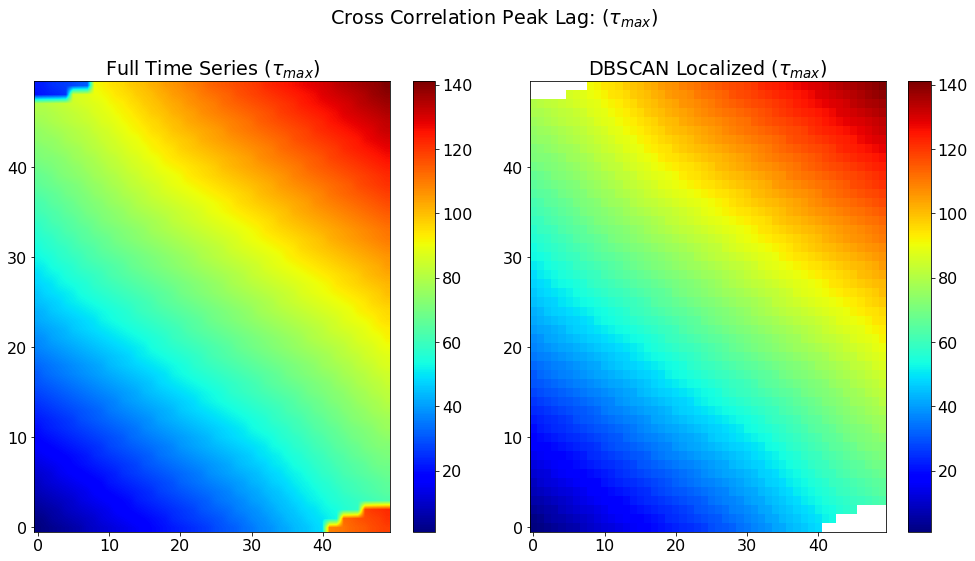

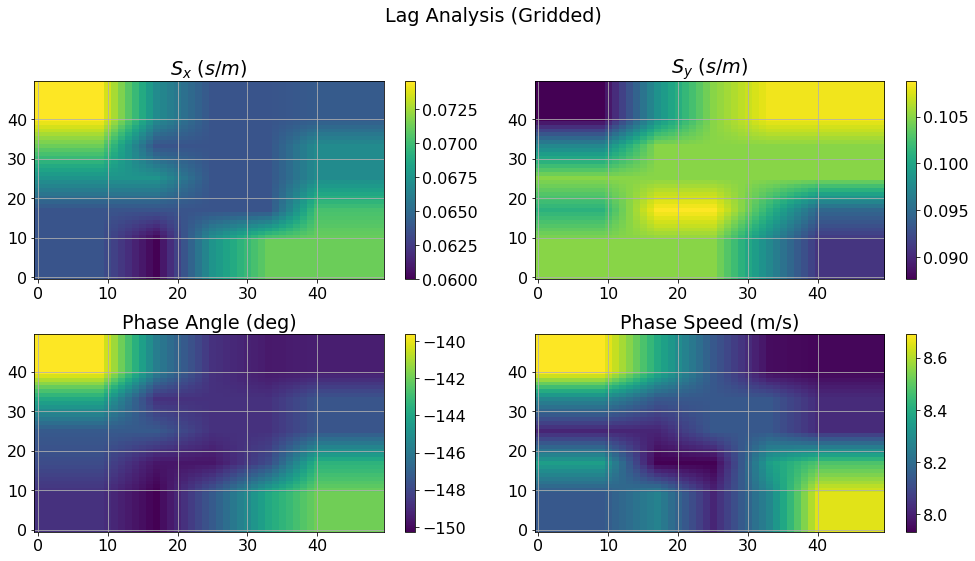

3.7523186179790016


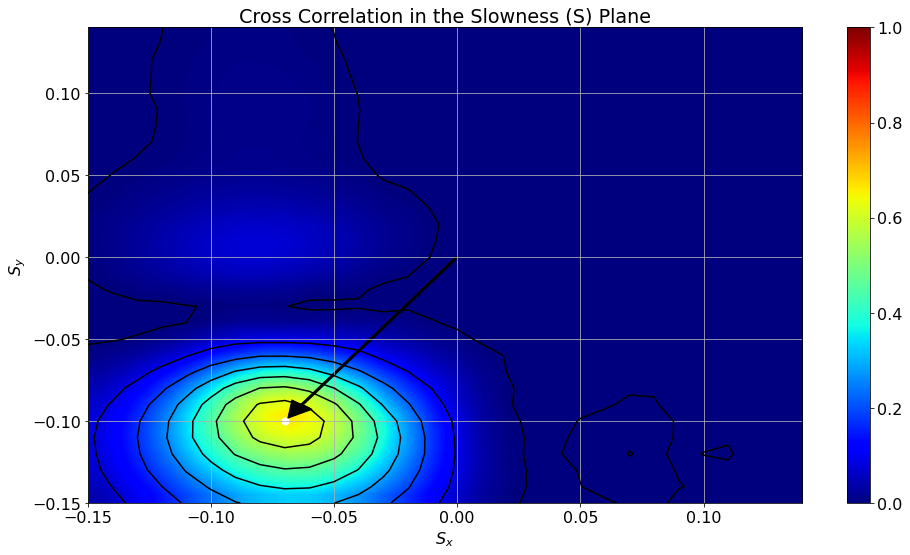

Direction From which Feature is Propagating
CC Lag Analysis: 213.0 degrees
Beamsteering: 215.0 degrees


In [23]:
### ---- (4) ---- ####
#Demonstrate how cross-correlation lag analysis and beamsteering are used to estimate phase speed and wave-normal wind components.

dx=8
#Perform lag analysis (retrieve lag times between sets of grid points)
st,et,cmax,u2,v2 = get_uv(parr,dx,True,True) #Use full 6-h time window and plot result
cmax,xx2,yy2,u2,v2 = get_uv(parr[st:et],dx,False) #Use windowing 
ugrid,vgrid,alpha_2d = grid_uv(xx2,yy2,u2,v2,dx,True) #Retrieve gridded estimates of phase speed/slowness components

#Compute mean tau (time difference between correlation peaks) 
um = np.mean(u2) 
vm = np.mean(v2)
alpha_ccmean = np.arctan2(-um,-vm) #Compute phase propagation from mean of gridded lag analysis
alpha_ccmean = alpha_ccmean 
if (alpha_ccmean < 0):
    alpha_ccmean = alpha_ccmean + 2*np.pi
elif (alpha_ccmean > 2*np.pi):
    alpha_ccmean = alpha_ccmean - 2*np.pi
    
#Track feature through composite analysis
if (sign == 'positive'):
    trj = get_track_pos(parr[st:et])
elif (sign == 'negative'):
    trj = get_track_neg(parr[st:et])

#Get wave-normal wind perturbation
uprime,umprime = get_unorm(uw,vw,u1,v1,alpha_2d)
#Retrieve azimuth of phase propagation angle, phase speed, and slowness components
alphab,cspeed,Sx,Sy = bsteer(parr,trj)
    
#Retrieve track points
txx = trj['x'].values
tyy = trj['y'].values

#get position of feature in 250 km x 250 km composite domain
tfrm = list(np.int32(trj['frame'].values+st+72))
#Intepolate trajectories to resolution of one frame (i.e. ensure we have one track point per frame)
frm1 = np.arange(tfrm[0],tfrm[-1]+1)
#If the trajectory has fewer points than the number of frames in the Case I analysis window extrapolate the trajectory to the beginning/end of the analysis window
if (len(frm1) != len(tfrm)):
        txx = np.interp(frm1,np.float32(tfrm),txx)
        tyy = np.interp(frm1,np.float32(tfrm),tyy)
        tfrm = list(np.int32(frm1))

txx = np.int32(txx)
tyy = np.int32(tyy)

#Direction of Feature Propagation
print("Direction From which Feature is Propagating")
print("CC Lag Analysis: "+str(round(np.degrees(alpha_ccmean),0))+" degrees")
print("Beamsteering: "+str(round(np.degrees(alphab),0))+" degrees")

In [24]:
### ---- (5) ---- ####
#Perform wavelet analysis and cross wavelet analysis to evaluate multi-scale relationships between pressure, temperature, humidity, and wind perturbations
#Calculate and display wavelet cross correlation, coherence, and phase at all feature track points and at the dominant scale of the observed pressure feature

def plot_wav(dat1,dat2,var1,var2,vstr,tfrm,norm=True):
    n=len(dat1)
    #Set Wavelet Parameters
    dt = 5
    pad = 1       # pad the time series with zeroes (recommended)
    dj = 1/12     # this will do 4 sub-octaves per octave
    s0 = 2*dt    # this says start at a scale of 10 minutes
    j1 = 8./dj    # this says do 7 powers-of-two with dj sub-octaves each
    #mother=py_wavelets_orig.Paul(4)
    mother=py_wavelets_orig.Morlet(6) #Morlet(6)

    n2 = int(n/2)
    
    #Combine variables to form title string
    tit = var1+var2
    
    #Perform wavelet analysis (Torrence and Compo, 1998)
    n2 = int(n/2)
    #Retrieve wavelet power spectral density (PSD) for first variable
    W1, sj, freq0, coi0, _, _ = py_wavelets_orig.cwt(dat1, dt, dj=dj, s0=s0, J=j1,normalize=norm)
    #Convert frequency to period
    period = 1/freq0
    #Compute wavelet PSD for second variable
    W2, sj, freq0, coi0, _, _ = py_wavelets_orig.cwt(dat2, dt, dj=dj, s0=s0, J=j1,normalize=norm)
    #Compute wavelet cross-spectral density (using cross wavelet transform) between first and second variable.
    W3, coi, freq, sigx = py_wavelets_orig.xwt(dat1, dat2, dt, dj=dj, s0=s0, J=j1,normalize=norm,significance_level=0.95)
    #Retrieve wavelet cross coherence and wavelet cross phase
    W4, Wa4, coi2, freq, sigc = py_wavelets_orig.wct(dat1, dat2, dt, dj=dj, s0=s0, J=j1, sig=False)
    #Compute wavelet cross correlation and the maximum cross correlation (see Viana et al., 2010) 
    WCC,WCC_max,lags,freqs,coi2 = py_wavelets_orig.wcct(dat1, dat2, dt, dj=dj, s0=s0, J=j1, ln=n2, pad=1, s1=1, s2=6, significance_level=0.8646,wavelet=mother, mc_count=5, normalize=norm,cache=False)
    #Transpose wavelet cross correlation
    WCC = WCC.T

    WCC_max_t = WCC_max[tfrm] #Window the max wavelet cross correlation to frames when the pressure feature was present
    #Identify the frame at the center of the track window (i.e the time when the feature was at the center of the composite domain)
    #print(WCC_max.shape)
    if (sign == 'positive'):
        if ((var2 == "T'") or (var2 == "Td'")):
            mb = tfrm[0]+np.argmax(-1*WCC_max_t)
        else:
            mb = tfrm[0]+np.argmax(WCC_max_t)

    if (sign == 'negative'):
        if ((var2 == "T'") or (var2 == "Td'")):
            mb = tfrm[0]+np.argmax(WCC_max_t)
        else:
            mb = tfrm[0]+np.argmax(-1*WCC_max_t)

    mf = mb;
    #Set lower and upper limit for period (y-axis) in minutes
    s1 = 30; s2 = 6*60 #24*60
    #Define start and end index for y-axis
    s11 = np.argmin(abs(s1-period))
    s22 = np.argmin(abs(s2-period))

    #Compute square of wavelet power spectrum and rectify bias (Liu et al., 2007)
    p1 = (np.abs(W1))**2
    p2 = (np.abs(W2))**2
    p3 = (np.abs(W3))**2

    p1 /= sj[:, None]
    p2 /= sj[:, None]
    
    #Compute significance of wavelet PSD and wavelet cross-spectral density
    from helpers import ar1
    alpha = ar1(dat2)
    sig1, fft_theor = py_wavelets_orig.significance(1.0, dt, sj, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
    alpha = ar1(dat2)
    sig2, fft_theor = py_wavelets_orig.significance(1.0, dt, sj, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)

    sig1_95 = np.ones([1, n]) * sig1[:, None]
    sig1_95 = p1 / sig1_95

    sig2_95 = np.ones([1, n]) * sig2[:, None]
    sig2_95 = p2 / sig2_95

    sig3_95 = np.ones([1, n]) * sigx[:, None]
    sig3_95 = p3 / sig3_95

    #Define scale and time dimension
    scc2 = period.copy()
    scc = 2 ** np.arange(np.ceil(np.log2(period.min())),np.ceil(np.log2(period.max())))
    t = np.arange(-1*int(W1.shape[1]/2), int(W1.shape[1]/2))*5
    tc = np.arange(-1*int(WCC.shape[1]/2), int(WCC.shape[1]/2))*5

    #Set extent of wavelet analysis domain (x = time, y = scale/period)
    extent2 = [t.min(),t.max(), np.log2(scc2[0]),np.log2(scc2[-1])] #period.min(), period.max()] #np.log2(scc[0]),np.log2(scc[-1])]
    extentc = [tc.min(),tc.max(), np.log2(scc2[0]),np.log2(scc2[-1])] #period.min(), period.max()] #np.log2(scc[0]),np.log2(scc[-1])]

    #Set start and end time (i.e. 12-h time window centered at the time of the feature's passage)
    st = -6*60
    et = 6*60

    #Get index of start and end time
    t0 = np.argmin(abs(t-st))
    t1 = np.argmin(abs(t-et))

    #Set min and max threhsolds for colorbars
    minn = np.percentile(p1[s11:s22,t0:t1],1)
    maxx = np.percentile(p1[s11:s22,t0:t1],99)

    #Define time dimension for plotting
    t2 = t[t0:t1]

    fig0 = plt.figure(figsize=(20,7))
    #Plot high pass filtered mesoscale perturbation time-series
    ax1 = plt.subplot(131)
    ax1.plot(t2,dat1[t0:t1],'-k',color='royalblue')
    ax1.set_ylabel(var1, color='royalblue',rotation=270,labelpad=15)
    ax1.tick_params(axis='y', labelcolor='royalblue')
    plt.title('High Pass (0-6h) Time Series')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel(var2, color='forestgreen',rotation=270,labelpad=15)  # we already handled the x-label with ax1
    ax2.plot(t2, dat2[t0:t1], color='forestgreen')
    ax2.tick_params(axis='y', labelcolor='forestgreen')

    #Compute and plot the cross correlation between the two variables
    cctmp = xcr(dat1,dat2)
    plt.grid(True)
    plt.subplot(132)
    plt.plot(t,cctmp,'-k')
    plt.axvline(t[np.argmax(cctmp)],color='k',ls='--')
    plt.title('Cross Correlation')
    plt.grid(True)

    #Plot the amplitude of the maximum cross correlation (as a function of time)
    plt.subplot(133)
    plt.plot(t,WCC_max)
    plt.axvline(t[np.argmax(WCC_max)],color='k',ls='--')
    plt.title('Wavelet Cross Correlation Amplitude')
    plt.grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.suptitle(tit)
    plt.show()
    
    #Display results of wavelet analyses
    fig = plt.figure(figsize=(24,12))
    
    #Plot wavelet power spectral density
    ax1 = plt.subplot(231)
    im1=ax1.imshow(p1, origin='lower', aspect='auto',extent = extent2, interpolation='bilinear',cmap=plt.cm.jet,vmin=minn,vmax=maxx) #,vmin=1e-9,vmax=1e-1)
    #Contour region of where wavelet PSD is significant at the 95% confidence level 
    ax1.contour(t, np.log2(period), sig1_95, [-99, 1], colors='k', linewidths=2,extent=extent2)

    #Define cone of influence (i.e subject to edge-artificacts) and mark the area with hatching
    coi_area = np.concatenate([[np.max(period)], coi, [np.max(period)],[np.max(period)]])
    ts_area = np.concatenate([[t[0]], t, [t[-1]] ,[t[0]]]);

    L = ax1.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
    F=ax1.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

    #Retrieve the location of local maxima in wavelet PSD
    mnf1_l,p1_l,cx_1,cy_1 = get_contour(p1,period,t,coi)
    #Plot a mark indicating the local maxima in wavelet PSD
    ax1.scatter(t[cx_1],np.log2(period[cy_1]),c='w',s=50)
    #Plot a white contour around this mark representing the half-width of the peak (of PSD)
    ax1.contour(t, np.log2(period), p1_l, [mnf1_l], colors='w', linewidths=2,extent=extent2)
    
    #Retrieve the period(s) of the local maxima in wavelet PSD
    omega = period[cy_1]

    #Add plot labels and axis limits
    ax1.set_ylabel('Period (mins)')
    ax1.set_ylim(np.log2(scc[0]),np.log2(scc[-1]))
    ax1.set_yticks(np.log2(scc))
    ax1.set_yticklabels(scc)
    ax1.set_ylim([np.log2(s1),np.log2(s2)])
    ax1.set_xlim([st,et]) #t.min(),t.max()])
    ax1.set_title('Wavelet Power Spectral Density ('+var1+')')
    plt.grid(True)
    plt.colorbar(im1)
    
    #Update PSD limits for colorbar
    minn = np.percentile(p2[s11:s22,t0:t1],1)
    maxx = np.percentile(p2[s11:s22,t0:t1],99)
    
    #Plot the wavelet power spectral density for the second variable
    ax2 = plt.subplot(232)
    im2=ax2.imshow(p2, origin='lower', aspect='auto',extent = extent2, interpolation='bilinear',cmap=plt.cm.jet,vmin=minn,vmax=maxx) #,vmin=1e-9,vmax=1e-1)
    #Hatch COI
    L = ax2.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
    F=ax2.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")
    ax2.contour(t, np.log2(period), sig2_95, [-99, 1], colors='k', linewidths=2,extent=extent2)
    #Attempt to find a local maxima in wavelet PSD and contour PSD at the local half-width of the maxima (peak)
    try:
        mnf2_l,p2_l,cx_2,cy_2 = get_contour(p2,period,t,coi)
        ax2.contour(t, np.log2(period), p2_l, [mnf2_l], colors='w', linewidths=2,extent=extent2)
        ax2.scatter(t[cx_2],np.log2(period[cy_2]),c='w',s=50)
    except:
        pass
    
    #Add labels and set axis limits
    ax2.set_ylabel('Period (mins)')
    ax2.set_ylim(np.log2(scc[0]),np.log2(scc[-1]))
    ax2.set_yticks(np.log2(scc))
    ax2.set_yticklabels(scc)
    ax2.set_ylim([np.log2(s1),np.log2(s2)])
    ax2.set_xlim([st,et]) #t.min(),t.max()])
    ax2.set_title('Wavelet Power Spectral Density ('+var2+')')
    plt.grid(True)
    plt.colorbar(im2)
    
    #Define wavelet cross spectral density limits for colorbar
    minn = np.min(p3[s11:s22,t0:t1])
    maxx = np.max(p3[s11:s22,t0:t1])

    #Plot wavelet cross-spectral density
    ax3 = plt.subplot(233)
    #Mask Wavelet Phase where if not statisticall significant
    Wa3 = np.ma.masked_where(sig3_95<1,Wa4)
    im3=ax3.imshow(p3, origin='lower', aspect='auto',extent = extent2, interpolation='bilinear',cmap=plt.cm.jet,vmin=minn,vmax=maxx) #,vmin=1e-12,vmax=1e-1)
    #Add black contour to highlight region (within which) cross spectral density is statisticall significant at the 95% confidence level
    ax3.contour(t, np.log2(period), sig3_95, [-99, 1], colors='k', linewidths=2,extent=extent2)
    #Plot the cross wavelet phase (if significant)
    q1 = ax3.quiver(t[::6], np.log2(period)[::3], np.cos(Wa3[::3,::6]), np.sin(Wa3[::3,::6]),scale=25,zorder=10,linewidths=3) #np.cos(alpha),10*np.sin(alpha),scale=50,zorder=10)

    #Attempt to find a local maxima in wavelet PSD and contour PSD at the local half-width of the maxima (peak)
    try:
        mnf3_l,p3_l,cx_3,cy_3 = get_contour(p3,period,t,coi)
        ax3.contour(t, np.log2(period), p3_l, [mnf3_l], colors='w', linewidths=2,extent=extent2)
        ax3.scatter(t[cx_3],np.log2(period[cy_3]),c='w',s=50)
    except:
        pass

    #Hatch COI
    L = ax3.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
    F=ax3.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")
    
    #Add labels and set axis limits
    ax3.set_ylabel('Period (mins)')
    ax3.set_ylim(np.log2(scc[0]),np.log2(scc[-1]))
    ax3.set_yticks(np.log2(scc))
    ax3.set_yticklabels(scc)
    ax3.set_ylim([np.log2(s1),np.log2(s2)])
    ax3.set_xlim([st,et]) 
    ax3.set_title('Wavelet Cross Spectral Density')
    plt.grid(True)
    plt.colorbar(im3)

    #Plot wavelet cross coherence
    ax4 = plt.subplot(234)
    im4=ax4.imshow(W4, origin='lower', aspect='auto',extent = extent2, interpolation='bilinear',cmap=plt.cm.jet,vmin=0,vmax=1)
    #Hatch COI
    L = ax4.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
    F=ax4.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

    #Add labels and set axis limits
    ax4.set_ylabel('Period (mins)')
    ax4.set_ylim(np.log2(scc[0]),np.log2(scc[-1]))
    ax4.set_yticks(np.log2(scc))
    ax4.set_yticklabels(scc)
    plt.axvline(x=t[mf],color='k',ls='--',lw=2)
    ax4.set_ylim([np.log2(s1),np.log2(s2)])
    ax4.set_xlim([st,et]) #t.min(),t.max()])
    ax4.set_title('Wavelet Cross Coherence')
    plt.grid(True)
    plt.colorbar(im4)

    #Plot wavelet cross phase
    ax5 = plt.subplot(235)
    im5=ax5.imshow(Wa4, origin='lower', aspect='auto',extent = extent2, interpolation='bilinear',cmap=plt.cm.jet,vmin=-np.pi,vmax=np.pi)
    #Hatch COI
    L = ax5.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
    F=ax5.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")
    
    #Add labels and set axis limitws
    ax5.set_ylabel('Period (mins)')
    ax5.set_ylim(np.log2(scc[0]),np.log2(scc[-1]))
    ax5.set_yticks(np.log2(scc))
    ax5.set_yticklabels(scc)
    plt.axvline(x=t[mf],color='k',ls='--',lw=2)
    ax5.set_ylim([np.log2(s1),np.log2(s2)])
    ax5.set_xlim([st,et]) #t.min(),t.max()])
    ax5.set_title('Wavelet Cross Phase')
    plt.grid(True)
    plt.colorbar(im5)

    #WCC_ma = np.ma.masked_where(ps>0.05,WCC)
    #Plot wavelet cross correlation
    ax6 = plt.subplot(236)
    im6=ax6.imshow(WCC, origin='lower', aspect='auto',extent = extentc, interpolation='bilinear',cmap=plt.cm.RdBu_r,vmin=-1,vmax=1)
    #Hatch COI
    L = ax6.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
    F=ax6.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")
    #Plot time of max WCC amplitude
    plt.axvline(x=t[mb],color='k',ls='--',lw=2)
    ax6.set_ylabel('Period (mins)')
    ax6.set_ylim(np.log2(scc[0]),np.log2(scc[-1]))
    ax6.set_yticks(np.log2(scc))
    ax6.set_yticklabels(scc)
    ax6.set_ylim([np.log2(s1),np.log2(s2)])
    ax6.set_xlim([st,et]) #lags.min(),lags.max()]) #t.min(),t.max()])
    ax6.set_title('Wavelet Cross Correlation')
    plt.grid(True)
    plt.colorbar(im6)
    plt.show()

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


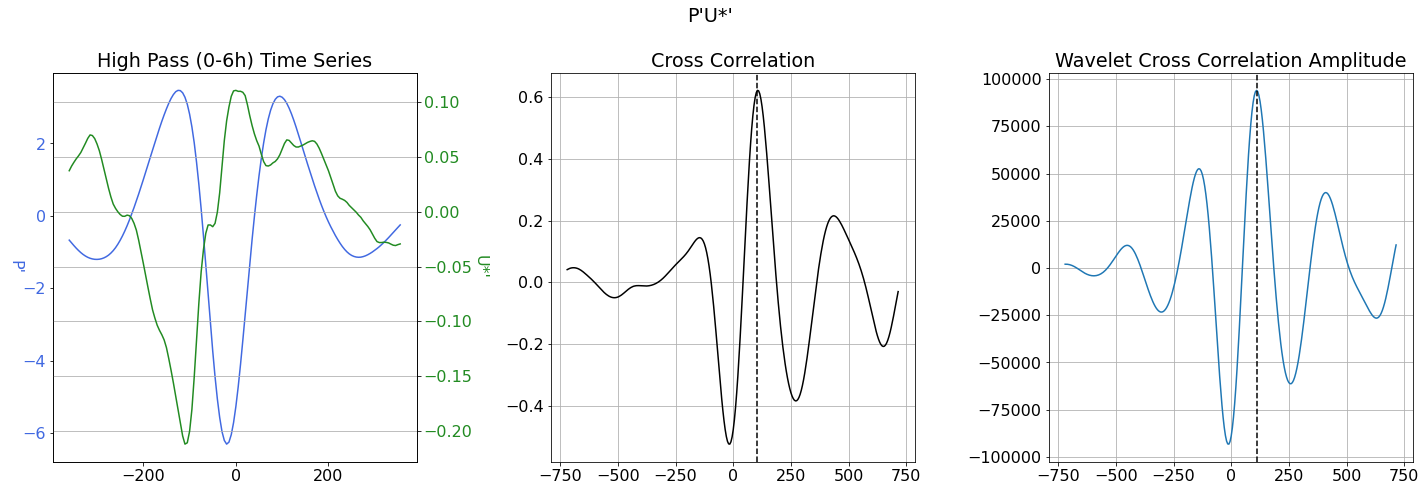

<ipython-input-24-9242f178a0f4>:153: UserWarning: No contour levels were found within the data range.
  ax1.contour(t, np.log2(period), sig1_95, [-99, 1], colors='k', linewidths=2,extent=extent2)
<ipython-input-24-9242f178a0f4>:193: UserWarning: No contour levels were found within the data range.
  ax2.contour(t, np.log2(period), sig2_95, [-99, 1], colors='k', linewidths=2,extent=extent2)
<ipython-input-24-9242f178a0f4>:223: UserWarning: No contour levels were found within the data range.
  ax3.contour(t, np.log2(period), sig3_95, [-99, 1], colors='k', linewidths=2,extent=extent2)


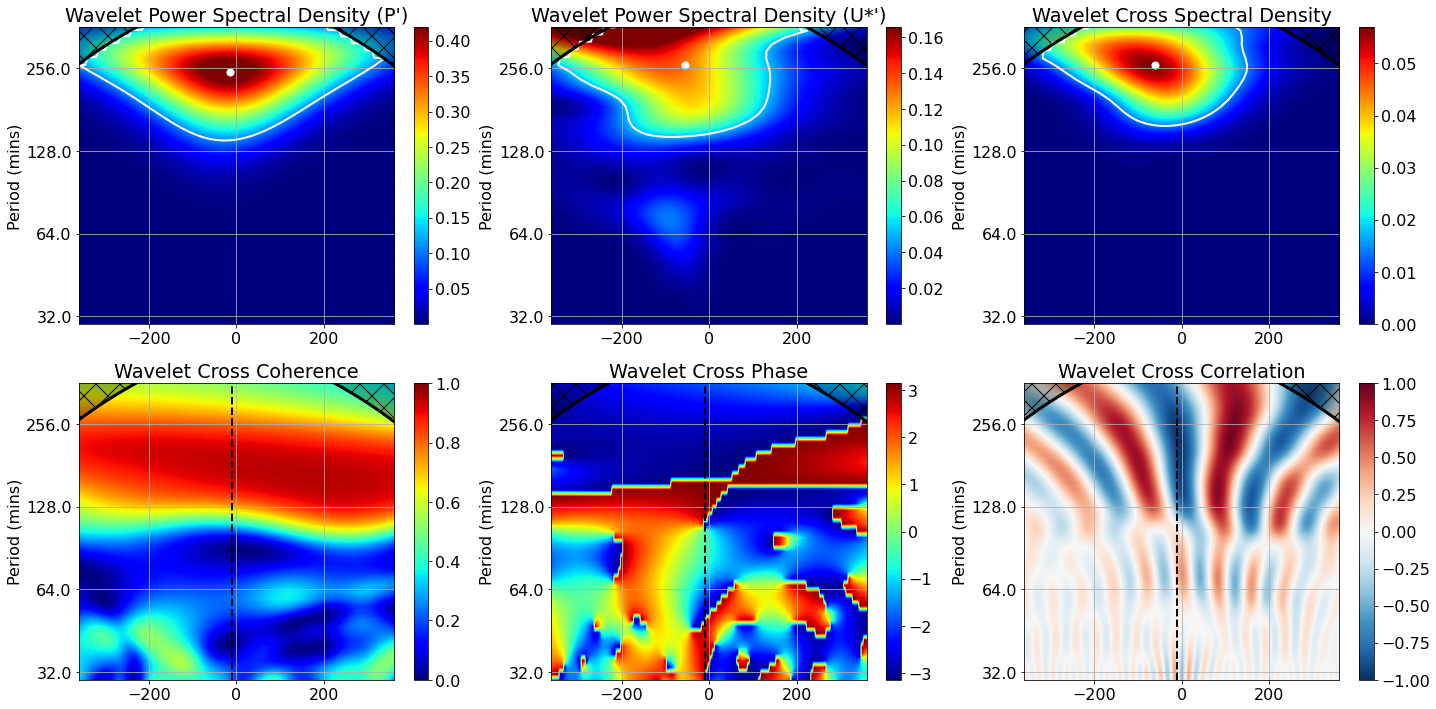

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


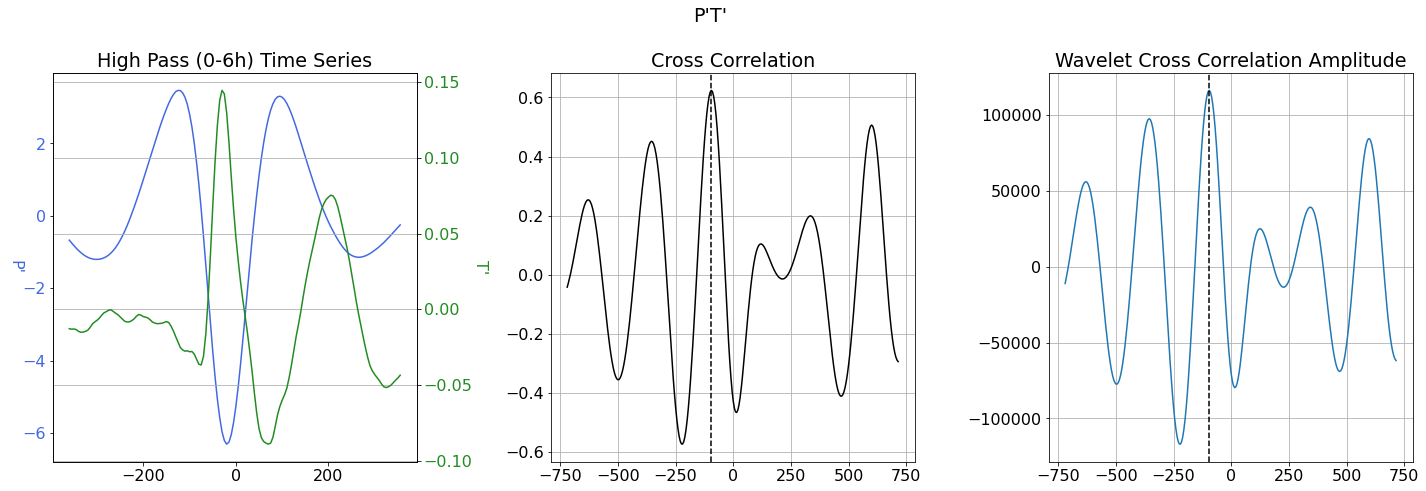

<ipython-input-24-9242f178a0f4>:153: UserWarning: No contour levels were found within the data range.
  ax1.contour(t, np.log2(period), sig1_95, [-99, 1], colors='k', linewidths=2,extent=extent2)
<ipython-input-24-9242f178a0f4>:193: UserWarning: No contour levels were found within the data range.
  ax2.contour(t, np.log2(period), sig2_95, [-99, 1], colors='k', linewidths=2,extent=extent2)
<ipython-input-24-9242f178a0f4>:223: UserWarning: No contour levels were found within the data range.
  ax3.contour(t, np.log2(period), sig3_95, [-99, 1], colors='k', linewidths=2,extent=extent2)


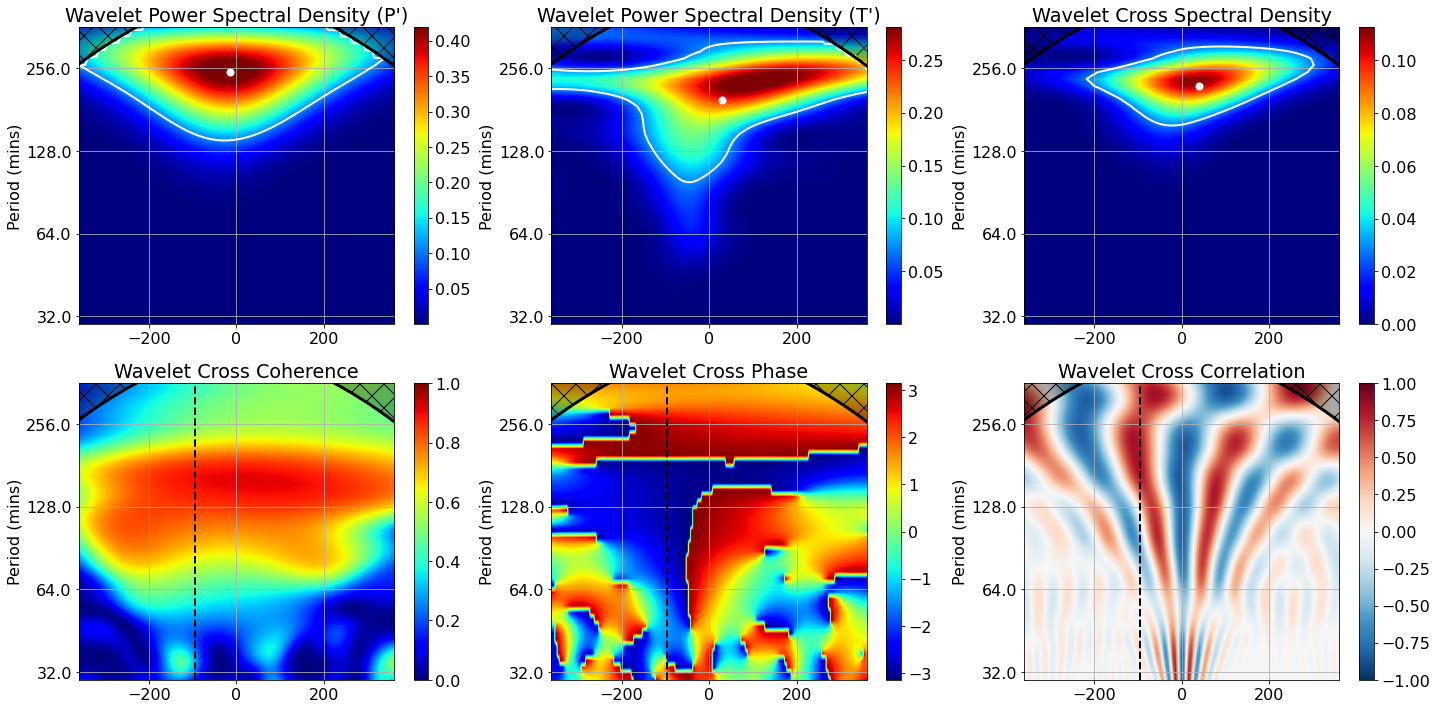

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


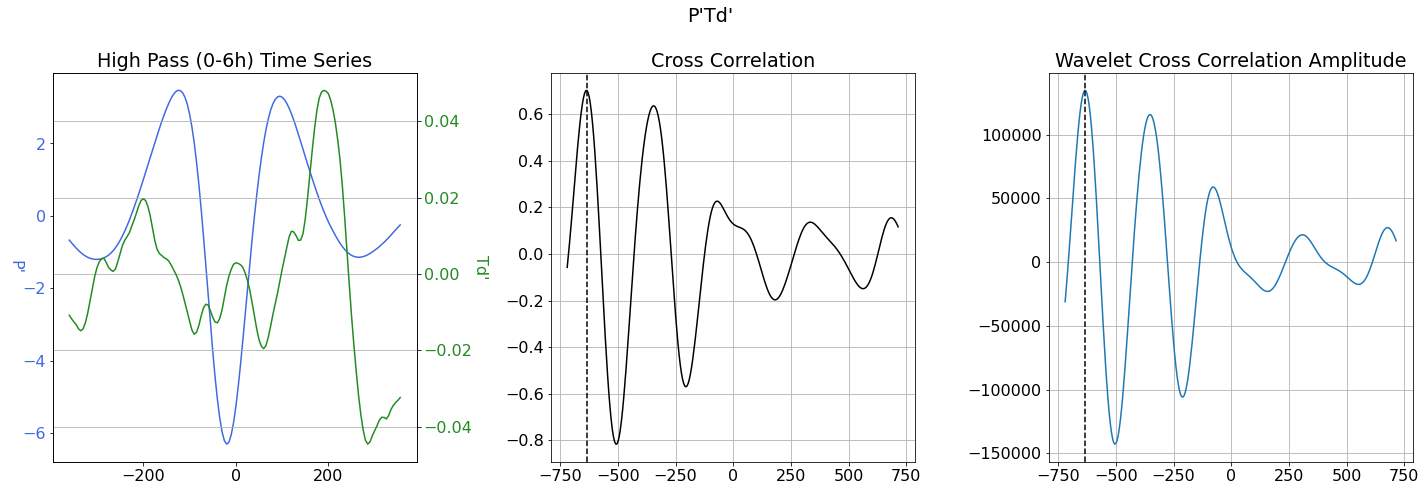

<ipython-input-24-9242f178a0f4>:153: UserWarning: No contour levels were found within the data range.
  ax1.contour(t, np.log2(period), sig1_95, [-99, 1], colors='k', linewidths=2,extent=extent2)
<ipython-input-24-9242f178a0f4>:193: UserWarning: No contour levels were found within the data range.
  ax2.contour(t, np.log2(period), sig2_95, [-99, 1], colors='k', linewidths=2,extent=extent2)
<ipython-input-24-9242f178a0f4>:223: UserWarning: No contour levels were found within the data range.
  ax3.contour(t, np.log2(period), sig3_95, [-99, 1], colors='k', linewidths=2,extent=extent2)


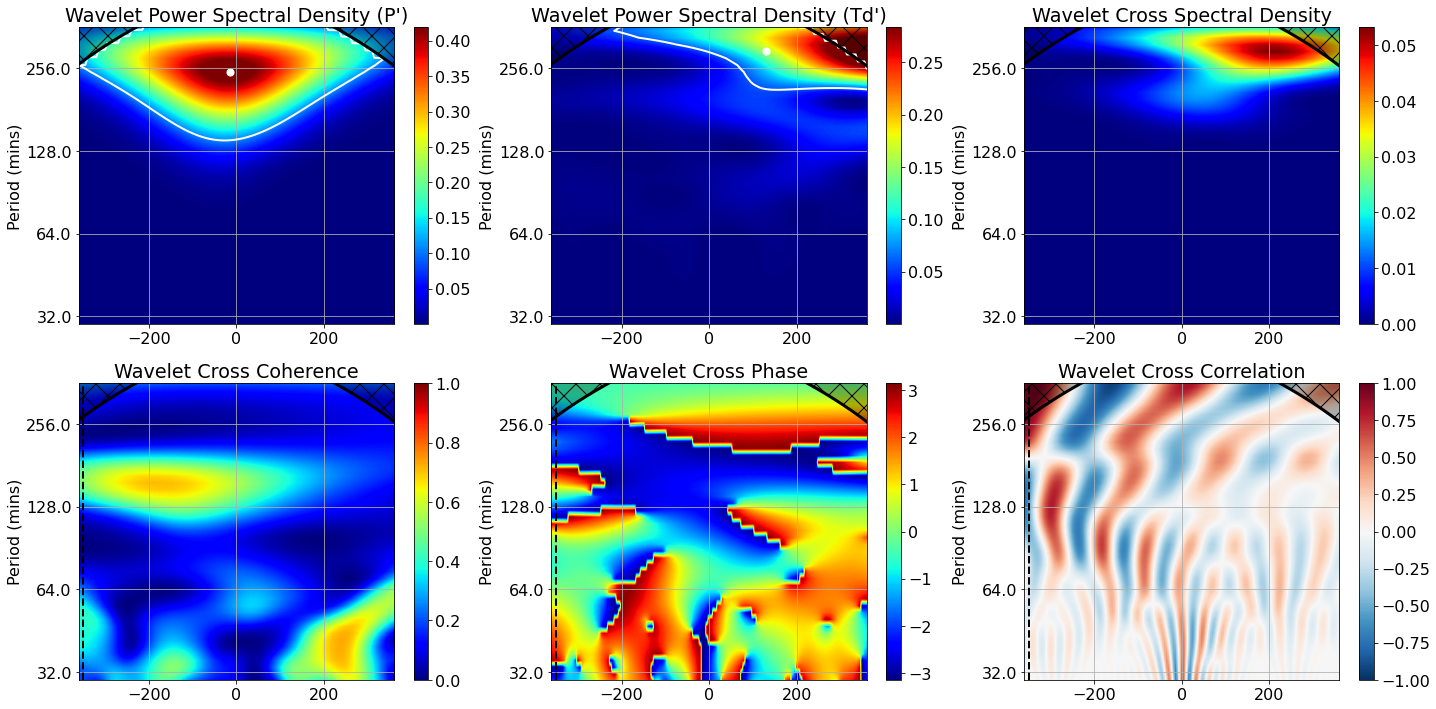

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


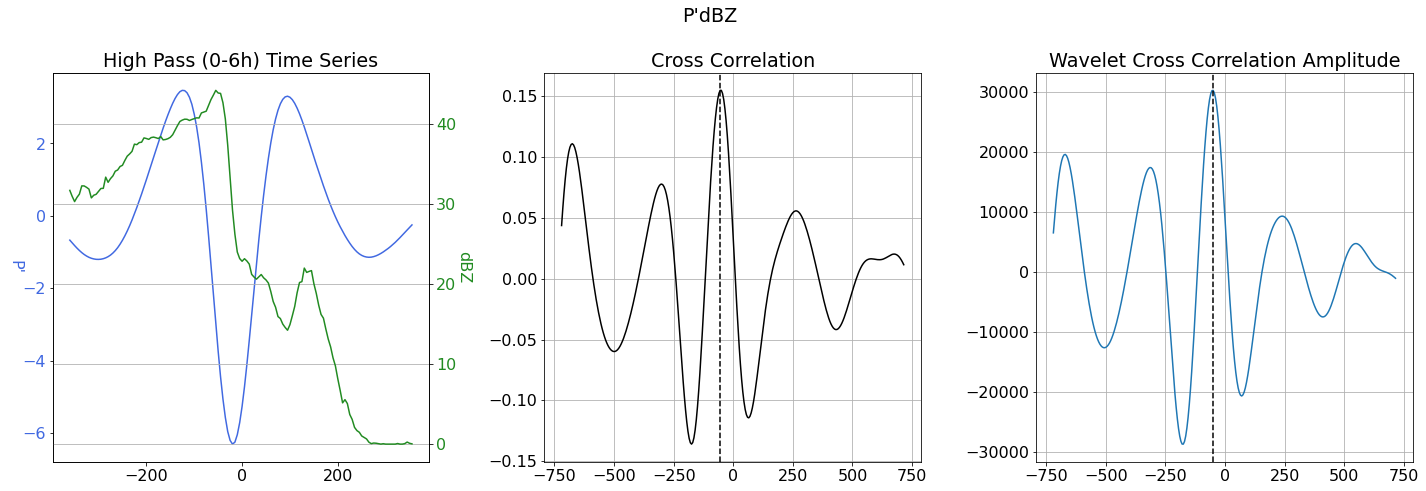

<ipython-input-24-9242f178a0f4>:153: UserWarning: No contour levels were found within the data range.
  ax1.contour(t, np.log2(period), sig1_95, [-99, 1], colors='k', linewidths=2,extent=extent2)
<ipython-input-24-9242f178a0f4>:223: UserWarning: No contour levels were found within the data range.
  ax3.contour(t, np.log2(period), sig3_95, [-99, 1], colors='k', linewidths=2,extent=extent2)


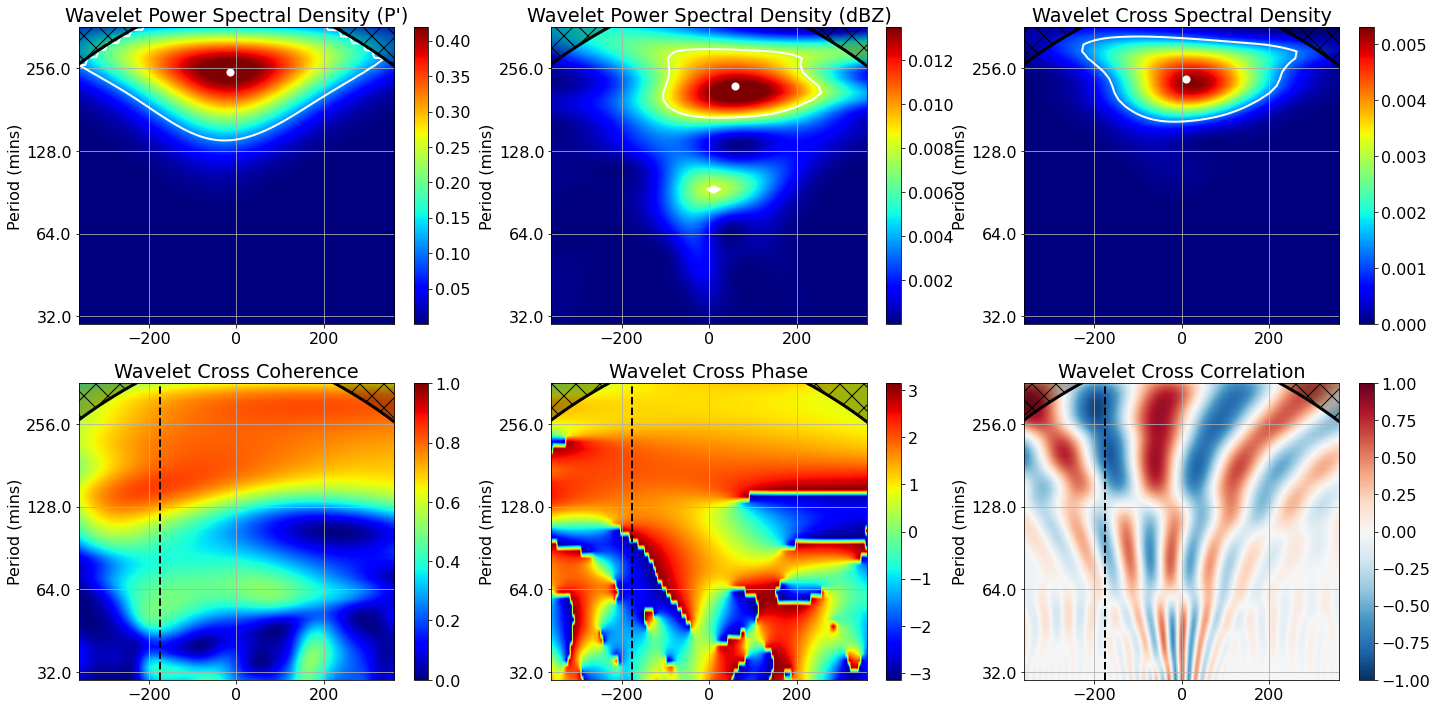

In [25]:
#Plot wavelet analysis for surface mesoscale perturbations

#Pressure and wave-normal wind
plot_wav(p1[:,24,24],uprime[:,24,24],"P'","U*'",'prs_wnd',tfrm,norm=True)
#Pressure and temperature
plot_wav(p1[:,24,24],t1[:,24,24],"P'","T'",'prs_tmp',tfrm,norm=True)
#Presusre and moisture
plot_wav(p1[:,24,24],d1[:,24,24],"P'","Td'",'prs_dpt',tfrm,norm=True)
#Pressure and reflectivity
plot_wav(p1[:,24,24],rf[:,24,24],"P'","dBZ",'prs_cref',tfrm,norm=True)

#Pressure CC Analysis
#T_mn1 = cross_anl(p1,uprime,'pressure','wind',txx,tyy,tfrm,nmi,"P'U*'",'prs_wnd')
#T_mn2 = cross_anl(p1,t1,'pressure','temperature',txx,tyy,tfrm,nmi,"P'T'",'prs_tmp')
#T_mn3 = cross_anl(p1,d1,'pressure','dewpoint',txx,tyy,tfrm,nmi,"P'Td'",'prs_dpt')
#T_mn4 = cross_anl(p1,rf,'pressure','reflectivity',txx,tyy,tfrm,nmi,"P'dBZ",'prs_rfl')

In [28]:
#Define a function to evaluate wavelet analysis parameters (e.g. cross correlation, cross phase, etc.) at each point along a feature track
#Note that wavelet analysis is performed for arrays 
def cross_anl(arr1,arr2,vvar1,vvar2,txx,tyy,tfrm,tit,vstr):
    
    #Retrieve wavelet parameters (e.g. scale, period, time, etc.)
    period,scc,tfull,coi,BW = get_per(arr1[:,24,24],arr2[:,24,24],norm=True)
    
    #Perform wavelet analysis for perturbation time-series drawn at each point in a feature's track (recall composite analysis is 3-D)
    results = Parallel(n_jobs=num_cores)(delayed(get_omg)(i,arr1[:,tyy[i],txx[i]],arr2[:,tyy[i],txx[i]],vvar2,tfrm,norm=True) for i in range(0,len(txx)))
    
    #Decipher results
    T = []; phase = []; ccoh = []; ccor = []; sbw = []; ppow = []
    for r in results:
        if (len(r[0]) == 1):
            if (r[0] == 0):
                 continue
        per = r[0]
        c1y = r[1]
        phs = r[2]
        coh = r[3]
        ccr = r[4]
        ppw = r[5]
        for i in range(0,len(per)):
            #Values valid at period and y-index of local maxima in wavelet PSD
            T.append(per[i]) #Period 
            sbw.append(BW[c1y[i]]) #Scale (log base 2)
            phase.append(phs[i]) #wavelet cross phase
            ccoh.append(coh[i]) #wavelet cross coherence
            ccor.append(ccr[i]) #wavelet cross correlation
            ppow.append(ppw[i]) #wavelet PSD
            
        
    T = np.array(T)
    sbw = np.array(sbw)
    phase = np.array(phase)
    ccoh = np.array(ccoh)
    ccor = np.array(ccor)
    ppow = np.array(ppow)

    ntim = np.arange(0,len(T))

    #Add wavelet parameters to xarray dataset
    dsp = xr.Dataset()
    dsp['T'] = xr.DataArray(T,coords={'ntims':ntim},dims=('ntims'))
    dsp['sbw'] = xr.DataArray(sbw,coords={'ntims':ntim},dims=('ntims'))
    dsp['phi'] = xr.DataArray(phase,coords={'ntims':ntim},dims=('ntims'))
    dsp['xcoh'] = xr.DataArray(ccoh,coords={'ntims':ntim},dims=('ntims'))
    dsp['xcorr'] = xr.DataArray(ccor,coords={'ntims':ntim},dims=('ntims'))
    dsp['ppow'] = xr.DataArray(ppow,coords={'ntims':ntim},dims=('ntims'))
    
    #Attempt to cluster wavelet cross correlation using scale (log base2) as a distance metric
    try:
        db = DBSCAN(eps=np.max(sbw),min_samples=int(len(T)*0.25))
        XX = np.array([ccor,T]).T
        db.fit(XX)
        kml = db.labels_
    except:
        return [0]
    
    ccor_mn = []; ccor_sd = []
    ccoh_mn = []; ccoh_sd = []
    phase_mn = []; phase_sd = []
    T_mn = []; sbw_mn = []; T_sd = []
    #Loop through unique clusters
    kun = np.unique(kml)
    for k in kun:
        #Calculate the mean and standard deviation of wavelet parameters falling within each cluster
        gidx = np.argwhere(kml==k).T[0]

        ccor_mn.append(np.mean(ccor[gidx]))
        ccor_sd.append(np.std(ccor[gidx]))

        ccoh_mn.append(np.mean(ccoh[gidx]))
        ccoh_sd.append(np.std(ccoh[gidx]))

        #Break the phase vector into components and compute the mean of each component
        up = np.cos(phase[gidx])
        vp = np.sin(phase[gidx])

        upm = np.mean(up)
        vpm = np.mean(vp)

        #Account for cyclical nature of phase calculation to ensure it fits within the -pi to +pi bounds
        if ((max(phase[gidx])-min(phase[gidx])) >= np.pi):
            phase_sd.append(np.arctan2(np.std(vp),np.std(up)))
            phase_mn.append(np.arctan2(vpm,upm))
        else:
            phase_mn.append(np.mean(phase[gidx]))
            phase_sd.append(np.std(phase[gidx]))

        #Calulate the mean scale and period
        sbw_mn.append(np.mean(sbw[gidx]))
        T_mn.append(np.mean(T[gidx]))
        T_sd.append(np.std(T[gidx]))

    ccor_mn = np.array(ccor_mn); ccor_sd = np.array(ccor_sd)
    phase_mn = np.array(phase_mn); phase_sd = np.array(phase_sd)
    ccoh_mn = np.array(ccoh_mn); ccoh_sd = np.array(ccoh_sd)
    T_mn = np.array(T_mn); sbw_mn = np.array(sbw_mn)

    #Load the wavelet scale dimension (log base2) from file
    scc = np.load("../../PyScripts/scc.npy")

    #Set unique color for each cluster
    kun = np.arange(0,len(sbw_mn))
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(kun))
    ccol = [cm.jet(norm(k)) for k in range(0,len(kun))]

    #Define limits for y-axis
    s1 = 30; s2 = 6*60
    ymin = np.log2(T_mn)-np.log2(T_mn-sbw_mn)
    ymax = np.log2(T_mn+sbw_mn)-np.log2(T_mn)

    fig = plt.figure(figsize=(20,7))

    #Scatter plot of wavelet coherence at lcoal maxima in wavelet PSD
    ax1=plt.subplot(131)
    #Denote uncertainty with standard deviation
    ax1.errorbar(ccoh_mn,np.log2(T_mn),yerr=[ymin,ymax],xerr=ccoh_sd,fmt='o',color='k')
    ax1.scatter(ccoh_mn,np.log2(T_mn),c=kun,s=50,zorder=3,cmap=plt.cm.jet)
    ax1.scatter(ccoh,np.log2(T),c=kml,s=10,zorder=3,alpha=0.2,cmap=plt.cm.jet)
    
    #Add labels and set axis limits
    plt.grid(True)
    ax1.set_ylabel('Period (mins)')
    ax1.set_yticks(np.log2(scc))
    ax1.set_yticklabels(scc)
    ax1.set_ylim([np.log2(s1),np.log2(s2)])
    ax1.set_title('Wavelet Cross Coherence')
    ax1.set_xlim([0,1])

    #Scatter plot of wavelet cross correlation at local maxima in wavelet PSD
    ax2 = plt.subplot(132)
    plt.grid(True)
    #Denote uncertainty with standard deviation
    ax2.errorbar(ccor_mn,np.log2(T_mn),yerr=[ymin,ymax],xerr=ccor_sd,fmt='o',color='k')
    ax2.scatter(ccor_mn,np.log2(T_mn),c=kun,s=50,zorder=3,cmap=plt.cm.jet)
    ax2.scatter(ccor,np.log2(T),c=kml,s=10,zorder=3,alpha=0.2,cmap=plt.cm.jet)
    #plt.axvline(x=0.75,color='k',ls='--',lw=2)
    ax2.set_ylabel('Period (mins)')
    ax2.set_yticks(np.log2(scc))
    ax2.set_yticklabels(scc)
    ax2.set_ylim([np.log2(s1),np.log2(s2)])
    ax2.set_title('Wavelet Cross Correlation')
    ax2.set_xlim([-1,1])

    #Scatter plot of wavelet cross phase at local maxima in wavelet PSD
    ax3 = plt.subplot(133)
    #Denote uncertainty with standard deviation
    ax3.errorbar(phase_mn,np.log2(T_mn),yerr=[ymin,ymax],xerr=phase_sd,fmt='o',color='k')
    ax3.scatter(phase_mn,np.log2(T_mn),c=kun,s=50,zorder=3,cmap=plt.cm.jet)
    ax3.scatter(phase,np.log2(T),c=kml,s=10,zorder=3,alpha=0.2,cmap=plt.cm.jet)

    #Set label and axis limits
    plt.grid(True)
    ax3.set_ylabel('Period (mins)')
    ax3.set_yticks(np.log2(scc))
    ax3.set_yticklabels(scc)
    ax3.set_ylim([np.log2(s1),np.log2(s2)])
    ax3.set_xlim([-np.pi,np.pi])
    ax3.set_xticks([-np.pi,-3*np.pi/4,-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
    ax3.set_xticklabels(["$-\pi$","$-3\pi/4$","$-\pi/2$","$-\pi/4$","$0$","$\pi/4$","$\pi/2$","$3\pi/4$","$\pi$"])
    ax3.set_title('Wavelet Cross Phase')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.suptitle(tit,weight='bold')
    plt.show()
    return T_mn

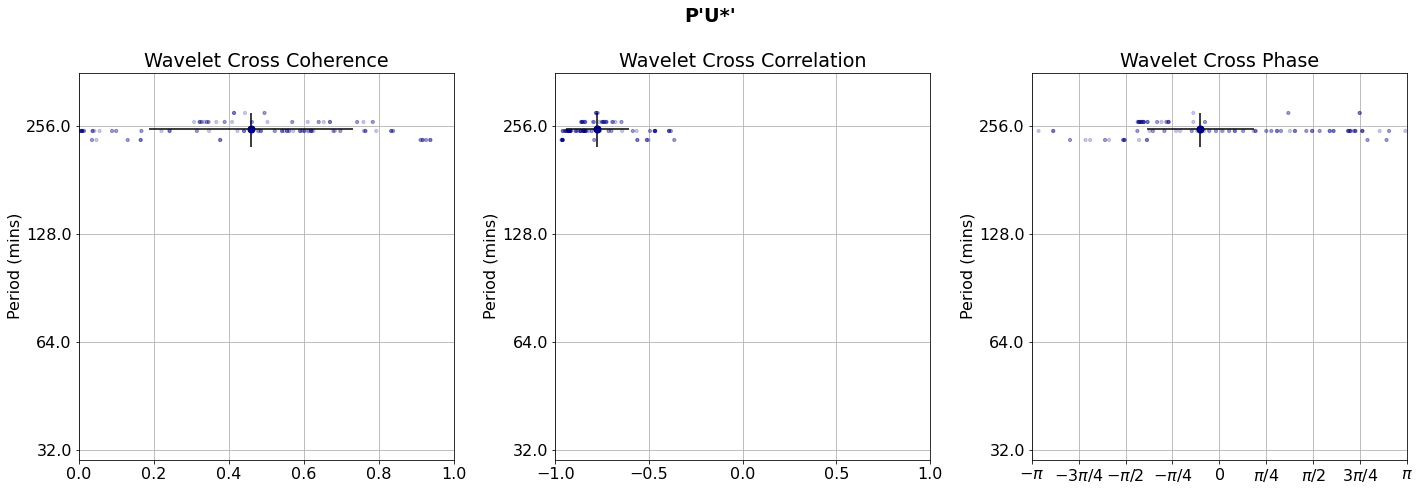

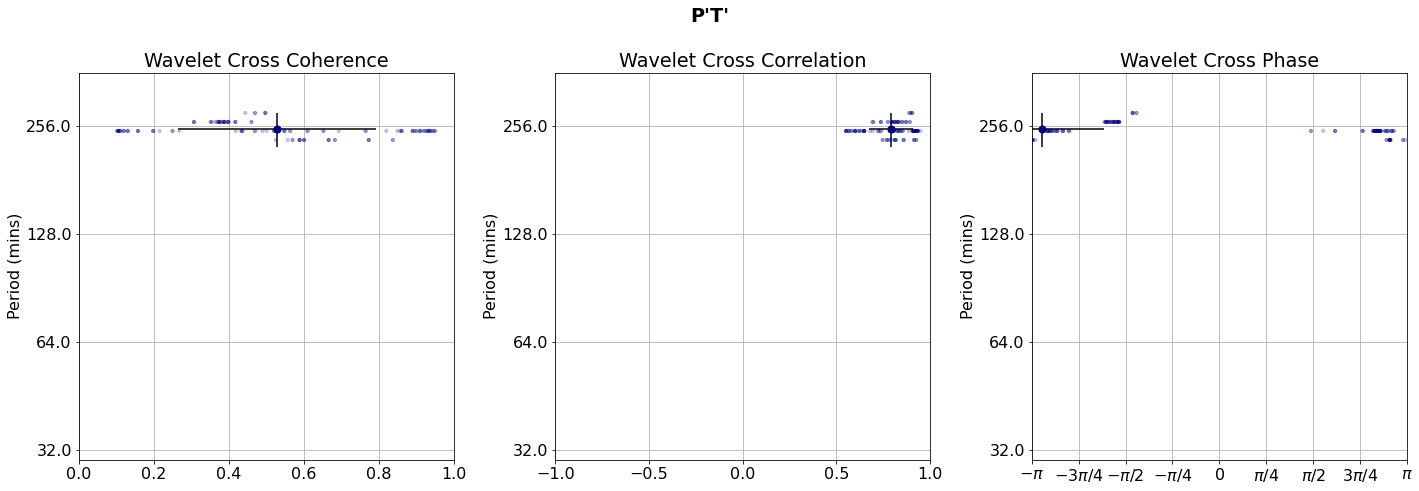

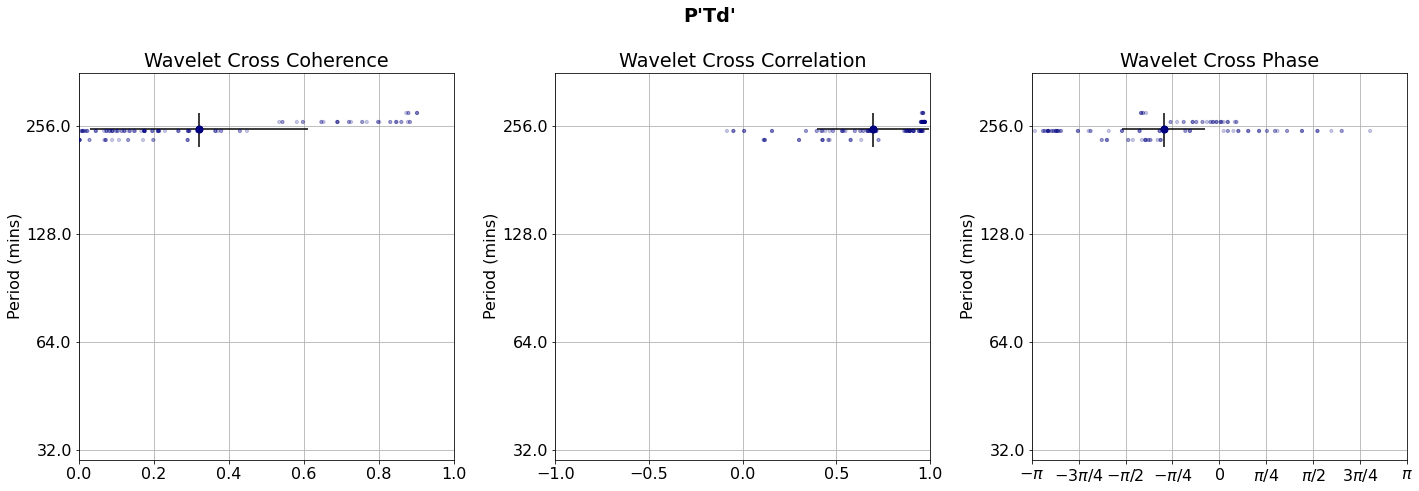

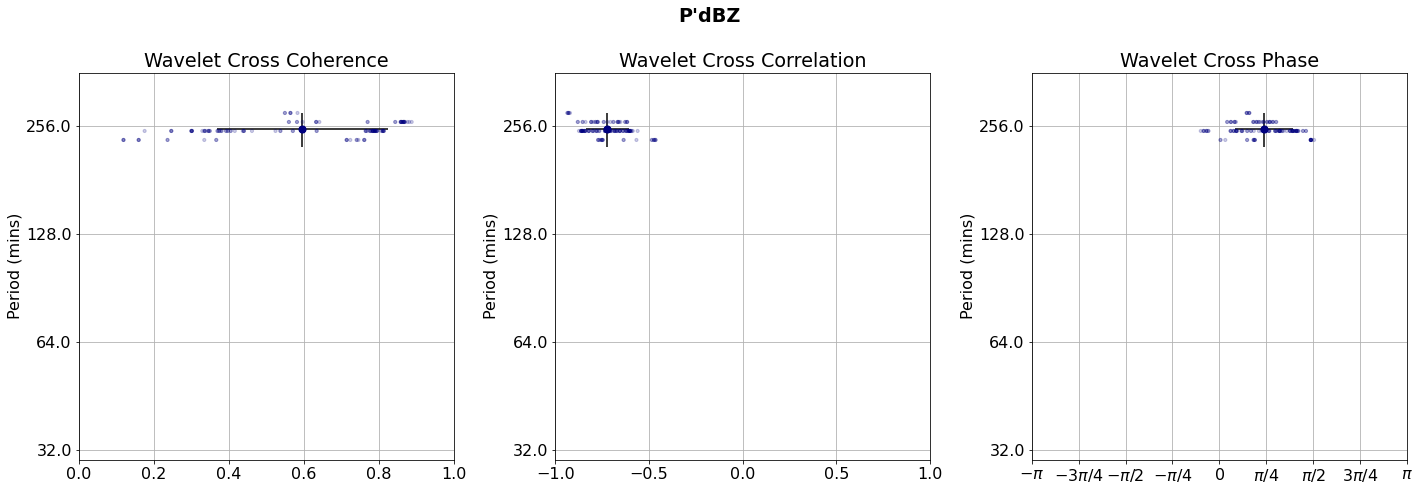

In [29]:
#Pressure CC Analysis
T_mn1 = cross_anl(p1,uprime,'pressure','wind',txx,tyy,tfrm,"P'U*'",'prs_wnd')
T_mn2 = cross_anl(p1,t1,'pressure','temperature',txx,tyy,tfrm,"P'T'",'prs_tmp')
T_mn3 = cross_anl(p1,d1,'pressure','dewpoint',txx,tyy,tfrm,"P'Td'",'prs_dpt')
T_mn4 = cross_anl(p1,rf,'pressure','reflectivity',txx,tyy,tfrm,"P'dBZ",'prs_rfl')

In [30]:
#Retrieve mean period of feature from wavelet analysis
T_mns = np.array([T_mn1,T_mn2,T_mn3,T_mn4])
for tt in T_mns:
    if (len(tt) == 1):
        if (tt == 0):
            continue
        else:
            T_mn = tt
    else:
        T_mn = tt
        break

#Use period/frequency to calculate phase speed of feature (from lag analysis and beamsteering)
cspeed_corr,cspeed_bm = get_cs(T_mn,um,vm,cspeed,dx)

#Speed of propagation
print('----------------')
print('Phase speed (CC Lag): '+str(round(cspeed_corr,2))+' m/s')
print('Phase speed (Beemsteering): '+str(round(cspeed_bm,2))+' m/s')

#Direction of propagation
print("Phase angle (CC lag): "+str(round(np.degrees(2*np.pi-alpha_ccmean),0))+" degrees")
print("Phase angle (Beamsteering): "+str(round(np.degrees(2*np.pi-alphab),0))+" degrees")

Period (T): 250 min
Wavelength (CC Lag): 123 km
----------------
Phase speed (CC Lag): 8.19 m/s
Phase speed (Beemsteering): 8.19 m/s
Phase angle (CC lag): 147.0 degrees
Phase angle (Beamsteering): 145.0 degrees
